In [29]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
import json
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin
from pyproj import Proj

In [30]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [31]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [32]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [33]:
shp.crs

{}

In [34]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')
wardCodeDict = {}
for index , row in ward_frame.iterrows():
    wardCodeDict[row['NAME']] = row['CODE']

In [35]:
wardCodeDict

{'Chessington South Ward': 'E05000405',
 'Tolworth and Hook Rise Ward': 'E05000414',
 'Berrylands Ward': 'E05000401',
 'Alexandra Ward': 'E05000266',
 'Beverley Ward': 'E05000402',
 'Coombe Hill Ward': 'E05000406',
 'Chessington North and Hook Ward': 'E05000404',
 'Surbiton Hill Ward': 'E05000413',
 'Old Malden Ward': 'E05000410',
 "St. Mark's Ward": 'E05000412',
 'Grove Ward': 'E05000408',
 'Canbury Ward': 'E05000403',
 'Norbiton Ward': 'E05000409',
 'Coombe Vale Ward': 'E05000407',
 'St. James Ward': 'E05000411',
 'Tudor Ward': 'E05000415',
 'Coulsdon East Ward': 'E05000150',
 'Selsdon and Ballards Ward': 'E05000162',
 'Coulsdon West Ward': 'E05000151',
 'Waddon Ward': 'E05000167',
 'Kenley Ward': 'E05000156',
 'Purley Ward': 'E05000159',
 'Sanderstead Ward': 'E05000160',
 'Heathfield Ward': 'E05000523',
 'Fairfield Ward': 'E05000614',
 'Broad Green Ward': 'E05000149',
 'West Thornton Ward': 'E05000168',
 'Bensham Manor Ward': 'E05000148',
 'Norbury Ward': 'E05000158',
 'New Addingto

/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/work/sagarj/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7fa64cfc44e0>)

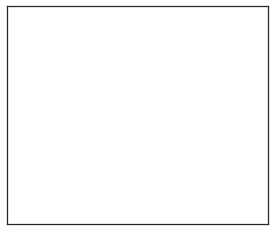

In [36]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '../Data/Geo_Data/geo/london_wards',
    'london',
    color='none',
    zorder=2)

In [37]:
m(58.6, -0)

(8381524.148273519, -5684368.573044857)

In [38]:
london_polys = []
borough_names = []
for w_ind in range(len(m.london_info)):
    w = m.london_info[w_ind]
    if w['CODE'] in borough_names:
        london_polys[-1] = Polygon(m.london[w_ind])
        continue
    borough_names.append(w['CODE'])    
    london_polys.append(Polygon(m.london[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [43]:
data_file1 = '../Data/Geo_Data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = '../Data/Geo_Data/greater_london_points.csv'
stephen_data = 'scratchpad/GLa_tree_loc.csv'

In [44]:
pd.read_csv(data_file1,sep='|').head()

WayID     PointID  Rotation  \
0   8363123  1077704848         0   
1  16790097   173736413         0   
2   7995502  1564517311         0   
3   8375945      195712         0   
4   2955913      629000         0   

                                        SegnetRatios  
0  [0.27945023148148146, 0.09033564814814815, 0.0...  
1  [0.2711574074074074, 0.24954282407407408, 0.00...  
2  [0.36464699074074075, 0.06125, 0.0211747685185...  
3  [0.2757118055555556, 0.14144675925925926, 0.00...  
4  [0.08201967592592592, 0.5701157407407408, 0.00...

In [45]:
Stephen_data = pd.read_csv(stephen_data)
Stephen_data .head()

GLA_ID   Tree  treePercen       lon        lat
0   37439   1437    0.008316 -0.160338  51.590471
1   71396  27531    0.159323  0.093273  51.351336
2   76511  24614    0.142442  0.039291  51.461303
3   53705   9961    0.057645 -0.021153  51.432981
4   71914  27405    0.158594  0.101934  51.399035

In [46]:

trees_dict = {'id':[], 'geometry':[] , 'treePercent':[]}
for index,row in Stephen_data.iterrows():
    trees_dict['id'].append(row['GLA_ID'])
    trees_dict['geometry'].append(Point(row['lon'],row['lat']))
    trees_dict['treePercent'].append(row['treePercen'])

In [47]:
Stephen_trees = pd.DataFrame.from_dict(trees_dict)

In [48]:
stephen_trees_gdf = gpd.GeoDataFrame(Stephen_trees, geometry='geometry', crs={'init':'EPSG:4326'})

In [49]:
stephen_trees_gdf.head()

id                   geometry  treePercent
0  37439.0  POINT (-0.16034 51.59047)     0.008316
1  71396.0   POINT (0.09327 51.35134)     0.159323
2  76511.0   POINT (0.03929 51.46130)     0.142442
3  53705.0  POINT (-0.02115 51.43298)     0.057645
4  71914.0   POINT (0.10193 51.39903)     0.158594

In [50]:
stephen_trees_WGS84 = stephen_trees_gdf.to_crs({'proj': 'tmerc','ellps' : 'WGS84'})

In [51]:
stephen_trees_gdf.head()

id                   geometry  treePercent
0  37439.0  POINT (-0.16034 51.59047)     0.008316
1  71396.0   POINT (0.09327 51.35134)     0.159323
2  76511.0   POINT (0.03929 51.46130)     0.142442
3  53705.0  POINT (-0.02115 51.43298)     0.057645
4  71914.0   POINT (0.10193 51.39903)     0.158594

In [52]:
stephen_trees_WGS84.head()

id                        geometry  treePercent
0  37439.0  POINT (-11111.867 5717790.119)     0.008316
1  71396.0    POINT (6497.965 5691176.612)     0.159323
2  76511.0    POINT (2730.687 5703407.654)     0.142442
3  53705.0   POINT (-1471.037 5700256.170)     0.057645
4  71914.0    POINT (7093.967 5696484.080)     0.158594

In [53]:
fdata_map_points = {}


for index, row in Stephen_data.iterrows():
    scene_list = [row['treePercen']]
    latitude  = row['lat']
    longitude = row['lon']
    fdata_map_points[m(longitude, latitude)] = scene_list

In [54]:
fdata_map_points

{(24144.939447465265, 35013.39745457863): [0.008315972],
 (42479.163198859664, 8884.716352782474): [0.15932291699999998],
 (38378.5364145888, 21011.490916408686): [0.14244213],
 (34263.42665516751, 17745.696871608117): [0.057644676],
 (42930.31383288189, 14207.854632994713): [0.15859375],
 (22204.712317725658, 21047.527936392027): [0.011990741000000001],
 (37042.03510687503, 11328.156634097482): [0.17117476899999998],
 (41363.20289404155, 29704.878040033014): [0.005237269],
 (28698.265682529833, 38395.7712275917): [0.106527778],
 (37849.83811945858, 29631.339056926925): [0.0044097220000000005],
 (36829.93121245279, 16510.16943928387): [0.023130787000000003],
 (26765.96689125002, 23198.32452027392): [0.056099537000000005],
 (41504.2293283327, 22385.48927509642): [0.141197917],
 (12183.774021349498, 34718.31037347441): [0.008668981],
 (24403.575709359313, 34951.45786527466): [0.21255787],
 (15108.448662302253, 33527.334768932225): [0.073877315],
 (21246.822183526587, 22661.604403610312):

In [61]:
# fdata_map_points.keys()

In [63]:
map_points = pd.Series([Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
print(len(plaque_points))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

104777


In [64]:
ldn_points

 ...]

In [65]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [68]:
df_map

poly borough_name  \
0    POLYGON ((13004.06946655408 5643.556705337571,...    E05000405   
1    POLYGON ((14432.57909437221 10890.80719853038,...    E05000414   
2    POLYGON ((14710.57509324689 12747.79659924857,...    E05000401   
3    POLYGON ((17083.95639092114 12354.05967221505,...    E05000400   
4    POLYGON ((18675.541683762 13589.62372095857, 1...    E05000402   
..                                                 ...          ...   
644  POLYGON ((29924.26240807216 26438.32918597994,...    E05009289   
645  POLYGON ((29614.24511027665 27061.95915219319,...    E05009295   
646  POLYGON ((29488.99825973884 27173.1999053428, ...    E05009299   
647  POLYGON ((30423.14740751 26418.42371497213, 30...    E05009308   
648  POLYGON ((29289.52747497862 26347.69316549817,...    E05009296   

           area_m    area_km  \
0    7.557384e+06  75.573841   
1    2.596590e+06  25.965904   
2    1.454965e+06  14.549655   
3    2.687010e+06  26.870103   
4    1.879597e+06  18.795975   
..            ...        ...   
644  1.123901e+05   1.123901   
645  8.162131e+04   0.816213   
646  1.507132e+05   1.507132   
647  6.292893e+04   0.629289   
648  5.212533e+04   0.521253   

                                     gsview_point_list  \
0    [POINT (14395.16284888203 9480.470449201151), ...   
1    [POINT (16259.86737917352 11068.04687376085), ...   
2    [POINT (15494.08747970358 12413.59817692518), ...   
3    [POINT (16733.06237564847 12604.16230425649), ...   
4    [POINT (17204.2266147552 13491.4796509991), PO...   
..                                                 ...   
644  [POINT (30102.79210341835 26569.14405422713), ...   
645  [POINT (29540.562080334 26944.30551812067), PO...   
646  [POINT (29168.4164149338 27125.83192274868), P...   
647  [POINT (30368.90121992026 26599.13579971032), ...   
648  [POINT (29415.02298660605 26454.10893679308), ...   

                               gsview_segnet_tags_dict  \
0    [[0.056689815], [0.041608796], [0.084826389], ...   
1    [[0.081915509], [0.04477430599999999], [0.0426...   
2    [[0.15564814800000001], [0.033940972], [0.1183...   
3    [[0.062546296], [0.050758102], [0.016105324], ...   
4    [[0.16829861100000001], [0.073796296], [0.0331...   
..                                                 ...   
644  [[0.015115741], [0.013541667], [0.121388889], ...   
645  [[0.0016666670000000001], [0.003854167], [0.00...   
646  [[0.000873843], [0.07961805599999999], [0.0254...   
647  [[0.02349537], [0.003761574], [0.028599537], [...   
648  [[0.000584491], [0.018385417], [0.000758102], ...   

                gsview_tags    total_gsview_pixels      Tree  TreeTotal  
0     [0.08016600295804195]   [11.463738422999999]  0.080166  11.463738  
1      [0.0563497430513089]        [10.7628009228]  0.056350  10.762801  
2     [0.10434428858415844]   [10.538773147000002]  0.104344  10.538773  
3      [0.0849857403986928]         [13.002818281]  0.084986  13.002818  
4     [0.06420874999199999]          [8.026093749]  0.064209   8.026094  
..                      ...                    ...       ...        ...  
644  [0.019608961728571427]         [0.6863136605]  0.019609   0.686314  
645  [0.013895502785714284]  [0.19453703899999997]  0.013896   0.194537  
646  [0.022412808681333336]   [0.6723842604400001]  0.022413   0.672384  
647  [0.015314078181818182]           [0.16845486]  0.015314   0.168455  
648  [0.004087009823529412]  [0.06947916700000001]  0.004087   0.069479  

[649 rows x 10 columns]

In [67]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
total_pixels = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
    total_pixels.append(np.sum(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags
df_map['total_gsview_pixels'] = total_pixels

# cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']
cats = ['Tree']

scene_tags_transpose = list(zip(*scene_tags))
scene_total_transpose = list(zip(*total_pixels))

for index in range(len(cats)):
    cat = cats[index]
    cat_total =  cats[index] + 'Total'
    df_map[cat] = scene_tags_transpose[index]
    df_map[cat_total] = scene_total_transpose[index]
    

In [69]:
np.array(df_map['gsview_segnet_tags_dict'].iloc[index])

array([[0.05668981],
       [0.0416088 ],
       [0.08482639],
       [0.0333044 ],
       [0.12553819],
       [0.09473958],
       [0.04586806],
       [0.00264468],
       [0.01460648],
       [0.03239583],
       [0.18480903],
       [0.01968171],
       [0.03433449],
       [0.07637732],
       [0.01539352],
       [0.16035301],
       [0.08165509],
       [0.09386574],
       [0.01223958],
       [0.14140625],
       [0.09905093],
       [0.07766782],
       [0.0379456 ],
       [0.01626736],
       [0.15552662],
       [0.00293982],
       [0.03681134],
       [0.05212384],
       [0.05287037],
       [0.02756366],
       [0.08910301],
       [0.16082755],
       [0.04175347],
       [0.0425    ],
       [0.07501157],
       [0.07645255],
       [0.01850116],
       [0.00599537],
       [0.17724537],
       [0.06833912],
       [0.09631366],
       [0.00766782],
       [0.14814815],
       [0.11355324],
       [0.14369213],
       [0.04235532],
       [0.01213542],
       [0.111

In [71]:
df_map['samples'] = df_map['gsview_point_list'].apply(lambda x: len(x))

In [72]:
df_map

poly borough_name  \
0    POLYGON ((13004.06946655408 5643.556705337571,...    E05000405   
1    POLYGON ((14432.57909437221 10890.80719853038,...    E05000414   
2    POLYGON ((14710.57509324689 12747.79659924857,...    E05000401   
3    POLYGON ((17083.95639092114 12354.05967221505,...    E05000400   
4    POLYGON ((18675.541683762 13589.62372095857, 1...    E05000402   
..                                                 ...          ...   
644  POLYGON ((29924.26240807216 26438.32918597994,...    E05009289   
645  POLYGON ((29614.24511027665 27061.95915219319,...    E05009295   
646  POLYGON ((29488.99825973884 27173.1999053428, ...    E05009299   
647  POLYGON ((30423.14740751 26418.42371497213, 30...    E05009308   
648  POLYGON ((29289.52747497862 26347.69316549817,...    E05009296   

           area_m    area_km  \
0    7.557384e+06  75.573841   
1    2.596590e+06  25.965904   
2    1.454965e+06  14.549655   
3    2.687010e+06  26.870103   
4    1.879597e+06  18.795975   
..            ...        ...   
644  1.123901e+05   1.123901   
645  8.162131e+04   0.816213   
646  1.507132e+05   1.507132   
647  6.292893e+04   0.629289   
648  5.212533e+04   0.521253   

                                     gsview_point_list  \
0    [POINT (14395.16284888203 9480.470449201151), ...   
1    [POINT (16259.86737917352 11068.04687376085), ...   
2    [POINT (15494.08747970358 12413.59817692518), ...   
3    [POINT (16733.06237564847 12604.16230425649), ...   
4    [POINT (17204.2266147552 13491.4796509991), PO...   
..                                                 ...   
644  [POINT (30102.79210341835 26569.14405422713), ...   
645  [POINT (29540.562080334 26944.30551812067), PO...   
646  [POINT (29168.4164149338 27125.83192274868), P...   
647  [POINT (30368.90121992026 26599.13579971032), ...   
648  [POINT (29415.02298660605 26454.10893679308), ...   

                               gsview_segnet_tags_dict  \
0    [[0.056689815], [0.041608796], [0.084826389], ...   
1    [[0.081915509], [0.04477430599999999], [0.0426...   
2    [[0.15564814800000001], [0.033940972], [0.1183...   
3    [[0.062546296], [0.050758102], [0.016105324], ...   
4    [[0.16829861100000001], [0.073796296], [0.0331...   
..                                                 ...   
644  [[0.015115741], [0.013541667], [0.121388889], ...   
645  [[0.0016666670000000001], [0.003854167], [0.00...   
646  [[0.000873843], [0.07961805599999999], [0.0254...   
647  [[0.02349537], [0.003761574], [0.028599537], [...   
648  [[0.000584491], [0.018385417], [0.000758102], ...   

                gsview_tags    total_gsview_pixels      Tree  TreeTotal  \
0     [0.08016600295804195]   [11.463738422999999]  0.080166  11.463738   
1      [0.0563497430513089]        [10.7628009228]  0.056350  10.762801   
2     [0.10434428858415844]   [10.538773147000002]  0.104344  10.538773   
3      [0.0849857403986928]         [13.002818281]  0.084986  13.002818   
4     [0.06420874999199999]          [8.026093749]  0.064209   8.026094   
..                      ...                    ...       ...        ...   
644  [0.019608961728571427]         [0.6863136605]  0.019609   0.686314   
645  [0.013895502785714284]  [0.19453703899999997]  0.013896   0.194537   
646  [0.022412808681333336]   [0.6723842604400001]  0.022413   0.672384   
647  [0.015314078181818182]           [0.16845486]  0.015314   0.168455   
648  [0.004087009823529412]  [0.06947916700000001]  0.004087   0.069479   

     samples  
0        143  
1        191  
2        101  
3        153  
4        125  
..       ...  
644       35  
645       14  
646       30  
647       11  
648       17  

[649 rows x 11 columns]

In [73]:
df_map['TreeScore_norm'] = (df_map['TreeTotal']/df_map['samples'])

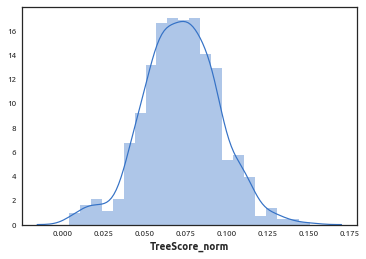

In [74]:
sns.distplot(df_map['TreeScore_norm'])

In [75]:
Tree_df = df_map[['borough_name','TreeScore_norm','samples']]

In [76]:
Tree_df.to_csv('Revised_tree_score.csv')

In [77]:
df_map.to_csv('London_ward_tree_scores_stephen.csv')

In [78]:
df_map.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm'],
      dtype='object')

In [80]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv',engine='python')

In [198]:
accesible_trees = gpd.read_file('scratchpad/accessible_trees.shp')

inaccessible_trees = gpd.read_file('scratchpad/inaccessible_trees.shp')

In [200]:
accesible_trees.head()

gla_id  borough               species_na common_nam display_na  \
0  glaid_1031  Barking            Tilia cordata       None       Lime   
1  glaid_1032  Barking        Malus tschonoskii       None      Apple   
2  glaid_1033  Barking  Liquidambar styraciflua       None      Other   
3  glaid_1034  Barking            Tilia cordata       None       Lime   
4  glaid_1035  Barking            Tilia cordata       None       Lime   

   load_date   easting  northing  longitude   latitude  ...  maxspeed  \
0   20180214  545308.0  183363.0   0.093434  51.530502  ...      None   
1   20180214  545314.0  183366.0   0.093517  51.530521  ...      None   
2   20180214  545335.0  183372.0   0.093831  51.530571  ...      None   
3   20180214  545352.0  183377.0   0.094073  51.530617  ...      None   
4   20180214  545370.0  183383.0   0.094331  51.530663  ...      None   

               name oneway     osmid   ref service         to tunnel width  \
0  Alfred's Gardens  False  33742448  None    None  385978878   None  None   
1  Alfred's Gardens  False  33742448  None    None  385978878   None  None   
2  Alfred's Gardens  False  33742448  None    None  385978878   None  None   
3  Alfred's Gardens  False  33742448  None    None  385978878   None  None   
4  Alfred's Gardens  False  33742448  None    None  385978878   None  None   

                   geometry  
0  POINT (0.09343 51.53050)  
1  POINT (0.09352 51.53052)  
2  POINT (0.09383 51.53057)  
3  POINT (0.09407 51.53062)  
4  POINT (0.09433 51.53066)  

[5 rows x 31 columns]

In [82]:
tree_data.head()

gla_id   borough                            species_name common_name  \
0  glaid_0  Barking   Acer pseudoplatanus 'brilliantissimum'         NaN   
1  glaid_1  Barking                 Taxus baccata fastigiata         NaN   
2  glaid_2  Barking                 Taxus baccata fastigiata         NaN   
3  glaid_3  Barking                 Taxus baccata fastigiata         NaN   
4  glaid_4  Barking                     Robinia pseudoacacia         NaN   

   display_name  load_date   easting  northing  longitude   latitude  
0         Maple   20180214  548320.0  189593.0   0.139454  51.585695  
1         Other   20180214  548297.0  189590.0   0.139123  51.585670  
2         Other   20180214  548289.0  189592.0   0.139004  51.585689  
3         Other   20180214  548298.0  189597.0   0.139134  51.585732  
4  Black Locust   20180214  548308.0  189607.0   0.139288  51.585819

In [201]:
AccessTreeData = pd.DataFrame.merge(accesible_trees,tree_data,left_on='gla_id',right_on='gla_id',how='inner')

In [203]:
InaccessTreeData = pd.DataFrame.merge(inaccessible_trees,tree_data,left_on='gla_id',right_on='gla_id',how='inner')

In [204]:
len(AccessTreeData), len(InaccessTreeData)

(404198, 379190)

In [206]:
AccessTreeData.columns

Index(['gla_id', 'borough_x', 'species_na', 'common_nam', 'display_na',
       'load_date_x', 'easting_x', 'northing_x', 'longitude_x', 'latitude_x',
       'index_righ', 'access', 'area', 'bridge', 'est_width', 'from',
       'highway', 'junction', 'key', 'lanes', 'length', 'maxspeed', 'name',
       'oneway', 'osmid', 'ref', 'service', 'to', 'tunnel', 'width',
       'geometry', 'borough_y', 'species_name', 'common_name', 'display_name',
       'load_date_y', 'easting_y', 'northing_y', 'longitude_y', 'latitude_y'],
      dtype='object')

In [207]:
treeLocations = []
for index , row in tree_data.iterrows():
    point = Point(m(row['longitude'], row['latitude']))
    treeLocations.append(point)

a_treeLocations = []
for index , row in AccessTreeData.iterrows():
    point = Point(m(row['longitude_x'], row['latitude_x']))
    a_treeLocations.append(point)
    
ina_treeLocations = []
for index , row in InaccessTreeData.iterrows():
    point = Point(m(row['longitude_x'], row['latitude_x']))
    ina_treeLocations.append(point)

In [208]:
print(len(treeLocations),len(a_treeLocations),len(ina_treeLocations))

726934 404198 379190


In [210]:
#All trees
tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['TreeCount'] = df_map['Tree_location_list'].map(lambda x: len(x))

In [211]:
#accessible Trees
tree_points = pd.Series(a_treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Accessible_Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['AccessibleTreeCount'] = df_map['Accessible_Tree_location_list'].map(lambda x: len(x))

In [212]:
#Inaccessible Trees
tree_points = pd.Series(ina_treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['InAccessible_Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['InaccessibleTreeCount'] = df_map['InAccessible_Tree_location_list'].map(lambda x: len(x))

In [213]:
df_map.head()

poly borough_name  \
0  POLYGON ((13004.06946655408 5643.556705337571,...    E05000405   
1  POLYGON ((14432.57909437221 10890.80719853038,...    E05000414   
2  POLYGON ((14710.57509324689 12747.79659924857,...    E05000401   
3  POLYGON ((17083.95639092114 12354.05967221505,...    E05000400   
4  POLYGON ((18675.541683762 13589.62372095857, 1...    E05000402   

         area_m    area_km                                  gsview_point_list  \
0  7.557384e+06  75.573841  [POINT (14395.16284888203 9480.470449201151), ...   
1  2.596590e+06  25.965904  [POINT (16259.86737917352 11068.04687376085), ...   
2  1.454965e+06  14.549655  [POINT (15494.08747970358 12413.59817692518), ...   
3  2.687010e+06  26.870103  [POINT (16733.06237564847 12604.16230425649), ...   
4  1.879597e+06  18.795975  [POINT (17204.2266147552 13491.4796509991), PO...   

                             gsview_segnet_tags_dict            gsview_tags  \
0  [[0.056689815], [0.041608796], [0.084826389], ...  [0.08016600295804195]   
1  [[0.081915509], [0.04477430599999999], [0.0426...   [0.0563497430513089]   
2  [[0.15564814800000001], [0.033940972], [0.1183...  [0.10434428858415844]   
3  [[0.062546296], [0.050758102], [0.016105324], ...   [0.0849857403986928]   
4  [[0.16829861100000001], [0.073796296], [0.0331...  [0.06420874999199999]   

    total_gsview_pixels      Tree  TreeTotal  samples  TreeScore_norm  \
0  [11.463738422999999]  0.080166  11.463738      143        0.080166   
1       [10.7628009228]  0.056350  10.762801      191        0.056350   
2  [10.538773147000002]  0.104344  10.538773      101        0.104344   
3        [13.002818281]  0.084986  13.002818      153        0.084986   
4         [8.026093749]  0.064209   8.026094      125        0.064209   

                                  Tree_location_list  TreeCount  \
0  [POINT (14517.96312475183 9426.15977958744), P...         91   
1  [POINT (16576.51872408381 10953.03509161706), ...         53   
2                                                 []          0   
3  [POINT (16524.99709332701 11497.43654868458), ...         74   
4                                                 []          0   

                       Accessible_Tree_location_list  AccessibleTreeCount  \
0  [POINT (14517.96312475183 9426.15977958744), P...                   66   
1  [POINT (16290.41194589755 11118.39502073106), ...                   60   
2                                                 []                    0   
3  [POINT (16524.99709332701 11497.43654868458), ...                   65   
4                                                 []                    0   

                     InAccessible_Tree_location_list  InaccessibleTreeCount  
0  [POINT (14312.18889693682 8994.298815162416), ...                     31  
1  [POINT (16576.51872408378 10953.03509161706), ...                     16  
2                                                 []                      0  
3  [POINT (16358.1360565441 11328.77328089604), P...                     24  
4                                                 []                      0

In [215]:
df_map.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list',
       'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount',
       'InAccessible_Tree_location_list', 'InaccessibleTreeCount'],
      dtype='object')

In [216]:
# %store df_map

Stored 'df_map' (DataFrame)


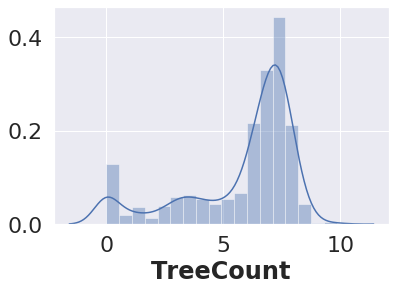

In [602]:
sns.distplot(np.log(df_map['TreeCount']+1))

In [606]:
np.mean(np.log(df_map['TreeCount']+1)) - 1*np.std(np.log(df_map['TreeCount']+1))

3.474233005587908

In [607]:
np.exp(3.47)

32.13674244475316

In [615]:
gdf = gpd.GeoDataFrame(df_map[df_map['TreeCount']>=32], crs={}, geometry='poly')

In [616]:
len(gdf)

534

In [617]:
gdf.head()

poly borough_name  \
0  POLYGON ((13004.069 5643.557, 13009.772 5652.2...    E05000405   
1  POLYGON ((14432.579 10890.807, 14440.082 10913...    E05000414   
3  POLYGON ((17083.956 12354.060, 17094.660 12346...    E05000400   
5  POLYGON ((18612.114 14742.451, 18536.285 14807...    E05000406   
6  POLYGON ((13778.042 9520.497, 13768.138 9631.5...    E05000404   

         area_m    area_km                                  gsview_point_list  \
0  7.557384e+06  75.573841  [POINT (14395.16284888203 9480.470449201151), ...   
1  2.596590e+06  25.965904  [POINT (16259.86737917352 11068.04687376085), ...   
3  2.687010e+06  26.870103  [POINT (16733.06237564847 12604.16230425649), ...   
5  4.424962e+06  44.249620  [POINT (17645.41376556331 16698.72950660242), ...   
6  1.931236e+06  19.312361  [POINT (15229.97449394081 10150.19215021402), ...   

                             gsview_segnet_tags_dict            gsview_tags  \
0  [[0.056689815], [0.041608796], [0.084826389], ...  [0.08016600295804195]   
1  [[0.081915509], [0.04477430599999999], [0.0426...   [0.0563497430513089]   
3  [[0.062546296], [0.050758102], [0.016105324], ...   [0.0849857403986928]   
5  [[0.060225694], [0.006215278], [0.125949074], ...  [0.09323976458433736]   
6  [[0.151521991], [0.16957754600000002], [0.0800...  [0.08236987200694444]   

    total_gsview_pixels      Tree  TreeTotal  samples  TreeScore_norm  \
0  [11.463738422999999]  0.080166  11.463738      143        0.080166   
1       [10.7628009228]  0.056350  10.762801      191        0.056350   
3        [13.002818281]  0.084986  13.002818      153        0.084986   
5  [15.477800921000002]  0.093240  15.477801      166        0.093240   
6        [11.861261569]  0.082370  11.861262      144        0.082370   

                                  Tree_location_list  TreeCount  \
0  [POINT (14517.96312475183 9426.15977958744), P...         91   
1  [POINT (16576.51872408381 10953.03509161706), ...         53   
3  [POINT (16524.99709332701 11497.43654868458), ...         74   
5  [POINT (18401.5742078253 15390.48764748624), P...         64   
6  [POINT (14505.65813144064 9519.194191265298), ...         39   

                       Accessible_Tree_location_list  AccessibleTreeCount  \
0  [POINT (14517.96312475183 9426.15977958744), P...                   66   
1  [POINT (16290.41194589755 11118.39502073106), ...                   60   
3  [POINT (16524.99709332701 11497.43654868458), ...                   65   
5  [POINT (18401.5742078253 15390.48764748624), P...                   48   
6  [POINT (14505.65813144064 9519.194191265298), ...                   65   

                     InAccessible_Tree_location_list  InaccessibleTreeCount  
0  [POINT (14312.18889693682 8994.298815162416), ...                     31  
1  [POINT (16576.51872408378 10953.03509161706), ...                     16  
3  [POINT (16358.1360565441 11328.77328089604), P...                     24  
5  [POINT (17861.16409853507 17508.66987919863), ...                     22  
6  [POINT (14605.59281010229 10022.58116152344), ...                      5

In [618]:
# gdf.to_csv('scratchpad/Tree_Segnet_stephen_data.csv')

In [619]:
# gdf.to_file('scratchpad/TreeGeopandas_accessibles.shp')

In [620]:
# df_map = pd.read_csv('Tree_Segnet.csv')

In [621]:
gdf['total_gsview_pixels'].iloc[2]

array([13.00281828])

In [622]:
sum(gdf['AccessibleTreeCount'])

403444

In [623]:
polygon = gdf.iloc[15]['poly']

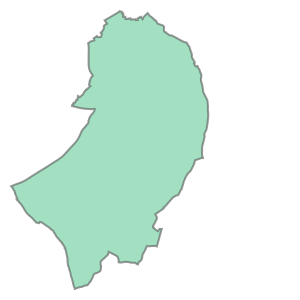

In [624]:
polygon

In [625]:
gdf.iloc[15].area_km

108.31036500518147

In [626]:
polygon.area

10831036.500518147

In [627]:
# df_map.to_csv('Tree_Segnet.csv')

In [628]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = gdf['TreeCount'].values.astype(float)
x2 = gdf['Tree'].values.astype(float)

minVal = float(np.min(x))
maxVal = float(np.max(x))

min_tree = float(np.min(x2))
max_tree = float(np.max(x2))

gdf['NormedTreeCount'] = (gdf['TreeCount']-minVal)/(maxVal-minVal)
gdf['NormedTreeSegnet'] = (gdf['Tree']-min_tree)/(max_tree-min_tree)

gdf['TreeDensity'] = np.log((gdf['TreeCount']*10.0)/gdf['area_km'])
gdf['AccessTreeDensity'] = np.log((gdf['AccessibleTreeCount']*10.0)/gdf['area_km'])
gdf['InAccessTreeDensity'] = np.log((gdf['InaccessibleTreeCount']*10.0+1)/gdf['area_km'])
# gdf['TreePixelDensity'] = np.log(gdf['TreeTotal']*10.0)/gdf['area_km']
gdf['TreePixelDensity'] = (gdf['TreeTotal']*10.0)/gdf['area_km']

In [629]:
gdf.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list',
       'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount',
       'InAccessible_Tree_location_list', 'InaccessibleTreeCount',
       'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity',
       'AccessTreeDensity', 'InAccessTreeDensity', 'TreePixelDensity'],
      dtype='object')

In [630]:
gdf.head()

poly borough_name  \
0  POLYGON ((13004.069 5643.557, 13009.772 5652.2...    E05000405   
1  POLYGON ((14432.579 10890.807, 14440.082 10913...    E05000414   
3  POLYGON ((17083.956 12354.060, 17094.660 12346...    E05000400   
5  POLYGON ((18612.114 14742.451, 18536.285 14807...    E05000406   
6  POLYGON ((13778.042 9520.497, 13768.138 9631.5...    E05000404   

         area_m    area_km                                  gsview_point_list  \
0  7.557384e+06  75.573841  [POINT (14395.16284888203 9480.470449201151), ...   
1  2.596590e+06  25.965904  [POINT (16259.86737917352 11068.04687376085), ...   
3  2.687010e+06  26.870103  [POINT (16733.06237564847 12604.16230425649), ...   
5  4.424962e+06  44.249620  [POINT (17645.41376556331 16698.72950660242), ...   
6  1.931236e+06  19.312361  [POINT (15229.97449394081 10150.19215021402), ...   

                             gsview_segnet_tags_dict            gsview_tags  \
0  [[0.056689815], [0.041608796], [0.084826389], ...  [0.08016600295804195]   
1  [[0.081915509], [0.04477430599999999], [0.0426...   [0.0563497430513089]   
3  [[0.062546296], [0.050758102], [0.016105324], ...   [0.0849857403986928]   
5  [[0.060225694], [0.006215278], [0.125949074], ...  [0.09323976458433736]   
6  [[0.151521991], [0.16957754600000002], [0.0800...  [0.08236987200694444]   

    total_gsview_pixels      Tree  TreeTotal  ...  \
0  [11.463738422999999]  0.080166  11.463738  ...   
1       [10.7628009228]  0.056350  10.762801  ...   
3        [13.002818281]  0.084986  13.002818  ...   
5  [15.477800921000002]  0.093240  15.477801  ...   
6        [11.861261569]  0.082370  11.861262  ...   

                       Accessible_Tree_location_list  AccessibleTreeCount  \
0  [POINT (14517.96312475183 9426.15977958744), P...                   66   
1  [POINT (16290.41194589755 11118.39502073106), ...                   60   
3  [POINT (16524.99709332701 11497.43654868458), ...                   65   
5  [POINT (18401.5742078253 15390.48764748624), P...                   48   
6  [POINT (14505.65813144064 9519.194191265298), ...                   65   

                     InAccessible_Tree_location_list  InaccessibleTreeCount  \
0  [POINT (14312.18889693682 8994.298815162416), ...                     31   
1  [POINT (16576.51872408378 10953.03509161706), ...                     16   
3  [POINT (16358.1360565441 11328.77328089604), P...                     24   
5  [POINT (17861.16409853507 17508.66987919863), ...                     22   
6  [POINT (14605.59281010229 10022.58116152344), ...                      5   

  NormedTreeCount  NormedTreeSegnet TreeDensity  AccessTreeDensity  \
0        0.003180          0.487075    2.488334           2.167130   
1        0.001132          0.314349    3.016093           3.140145   
3        0.002264          0.522029    3.315636           3.185958   
5        0.001725          0.581891    2.671621           2.383939   
6        0.000377          0.503058    3.005401           3.516227   

   InAccessTreeDensity  TreePixelDensity  
0             1.414683          1.516892  
1             1.824620          4.144974  
3             2.193783          4.839140  
5             1.608316          3.497838  
6             0.971080          6.141798  

[5 rows x 24 columns]

In [631]:
gdf['GSV_samples_per_sqkm'] = 0
samplesPerWard = {}
for index, row in gdf.iterrows():
    samplesPerWard[row['borough_name']] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    gdf.at[index,'GSV_samples_per_sqkm'] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    

In [632]:
gdf['decile'] = pd.qcut(gdf['GSV_samples_per_sqkm'], q=10, precision=0)

In [633]:
gdf['decile_treeDensity'] = pd.qcut(gdf['TreeDensity'], q=10, precision=0)

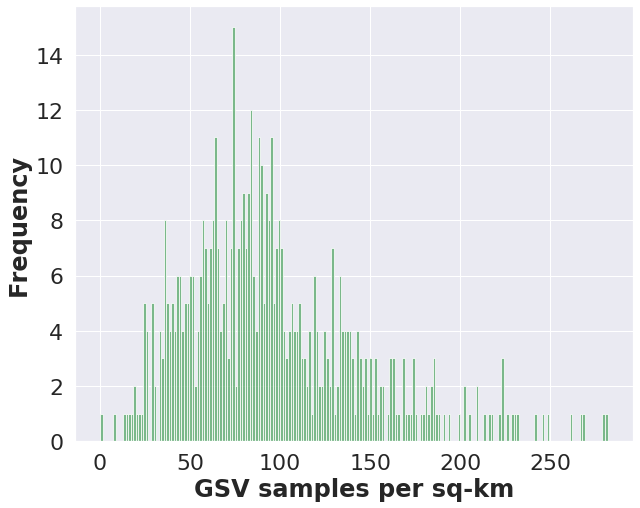

In [634]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('GSV samples per sq-km')
plt.ylabel('Frequency')
# plt.axvline(, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(samplesPerWard.values(), 200, facecolor='g', alpha=0.75)

In [653]:
print(list(gdf.columns))

['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list', 'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree', 'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list', 'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount', 'InAccessible_Tree_location_list', 'InaccessibleTreeCount', 'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity', 'AccessTreeDensity', 'InAccessTreeDensity', 'TreePixelDensity', 'GSV_samples_per_sqkm', 'decile', 'decile_treeDensity']


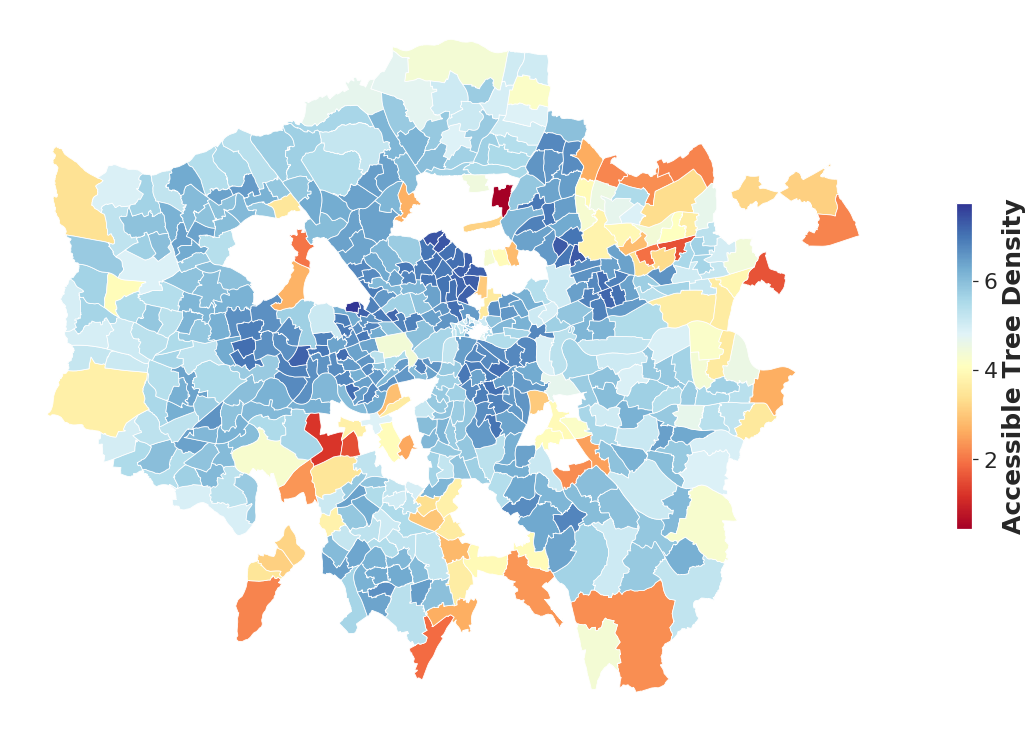

In [656]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=gdf['AccessTreeDensity'].min(), vmax=gdf['AccessTreeDensity'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('Accessible Tree Density', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
gdf[gdf['AccessTreeDensity']!=0.0].plot(ax=ax,column='AccessTreeDensity', cmap='RdYlBu', linewidth=0.8)


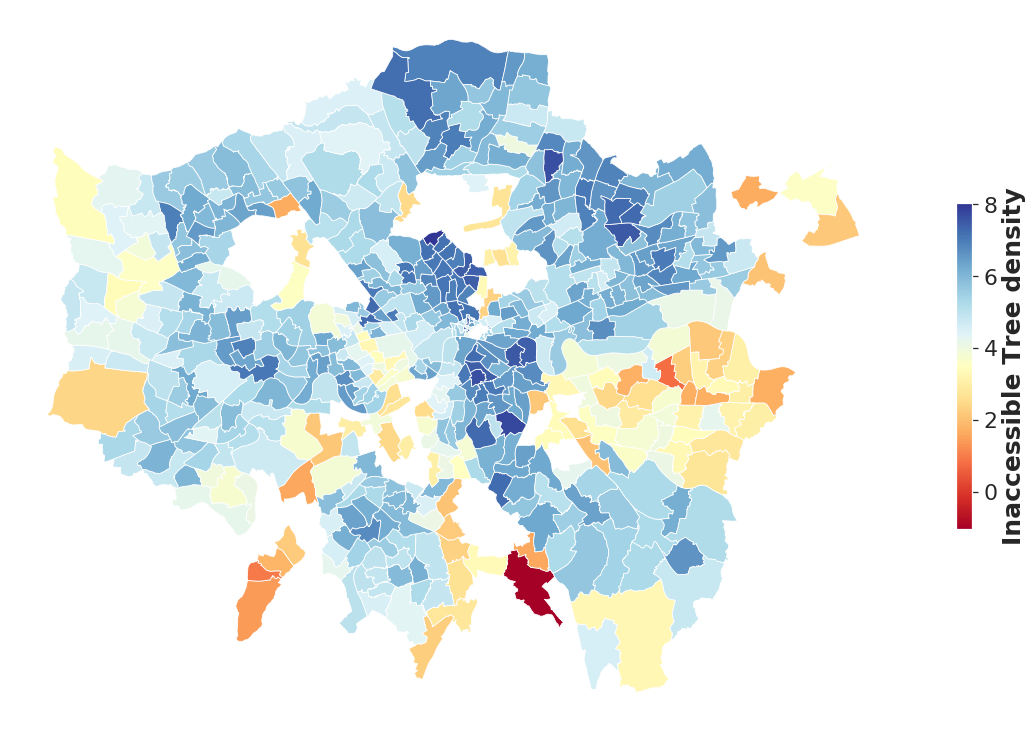

In [657]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=gdf['InAccessTreeDensity'].min(), vmax=gdf['InAccessTreeDensity'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('Inaccessible Tree density', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
gdf[gdf['InAccessTreeDensity']!=0.0].plot(ax=ax,column='InAccessTreeDensity', cmap='RdYlBu', linewidth=0.8)


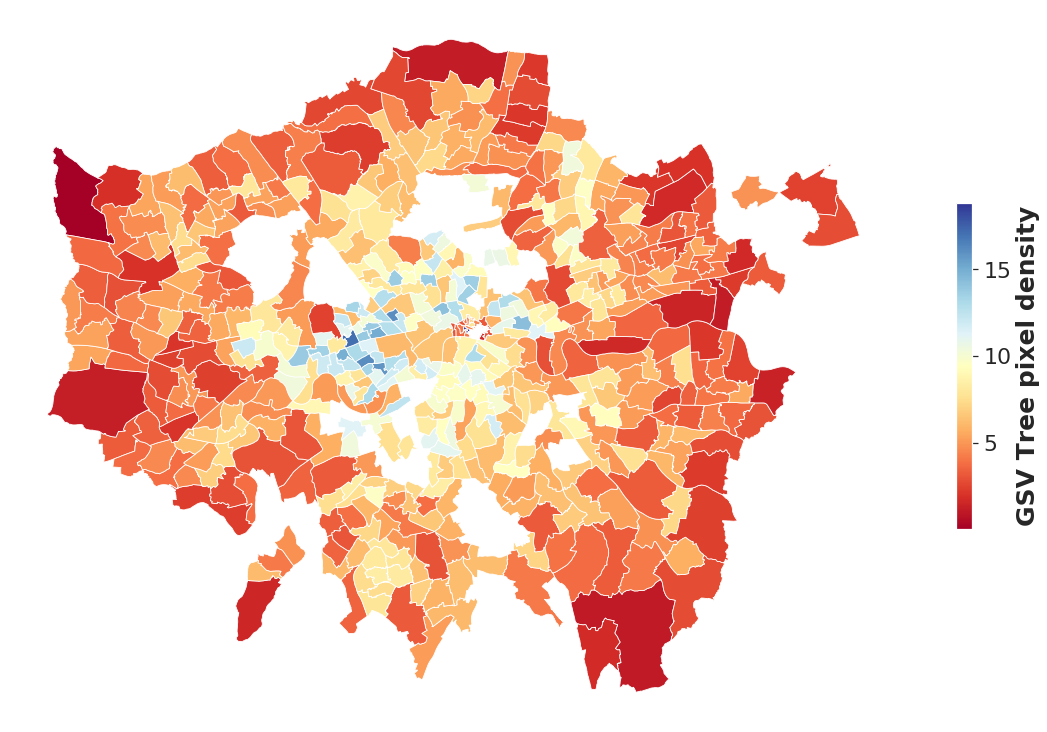

In [659]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=gdf['TreePixelDensity'].min(), vmax=gdf['TreePixelDensity'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('GSV Tree pixel density', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
gdf[gdf['TreePixelDensity']!=0.0].plot(ax=ax,column='TreePixelDensity', cmap='RdYlBu', linewidth=0.8)


In [660]:
from scipy.stats import pearsonr

In [661]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['TreeDensity'])
print(corr)

(0.36688949747784705, 1.8526883558378174e-18)


Text(12, 4, 'Pearson r: 0.36***')

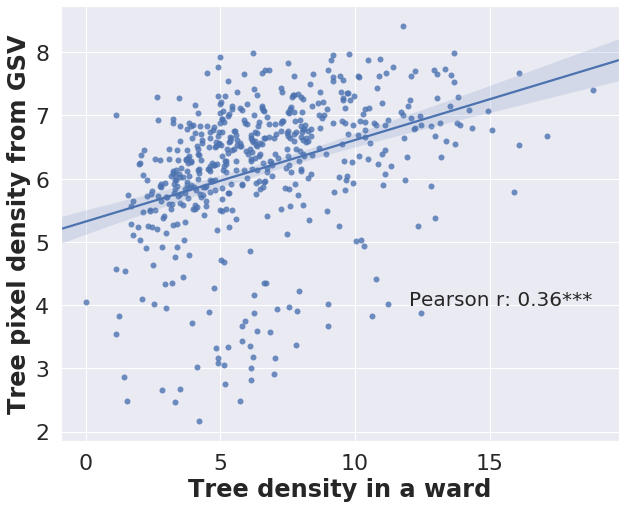

In [662]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="TreeDensity", data=gdf);
plt.xlabel('Tree density in a ward')
plt.ylabel('Tree pixel density from GSV')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(12, 4),fontsize = 20)

In [663]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['AccessTreeDensity'])
print(corr)

(0.45521142940680914, 1.1284846984080754e-28)


Text(12, 4, 'Pearson r: 0.45***')

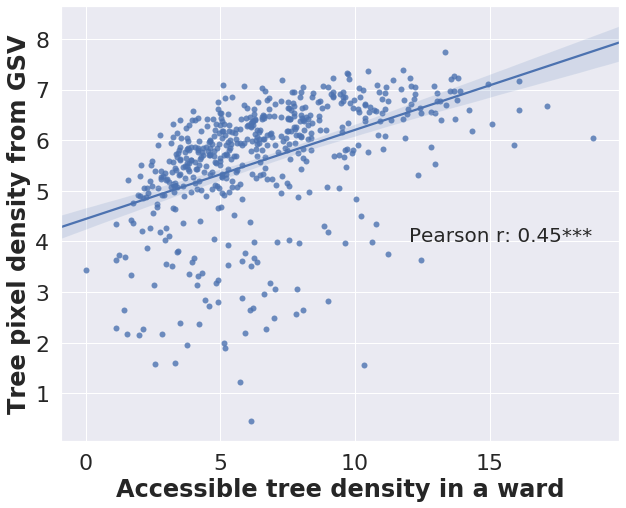

In [664]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="AccessTreeDensity", data=gdf);
plt.xlabel('Accessible tree density in a ward')
plt.ylabel('Tree pixel density from GSV')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(12, 4),fontsize = 20)

In [665]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['InAccessTreeDensity'])
print(corr)

(0.19952546161505827, 3.3725334282839107e-06)


Text(12, 4, 'Pearson r: 0.19***')

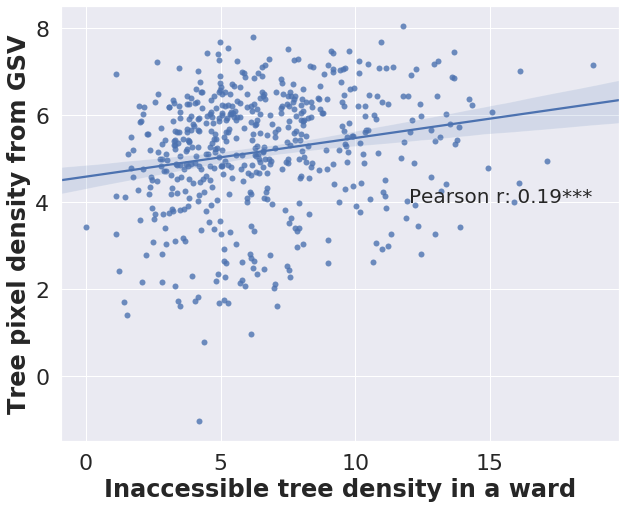

In [666]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="InAccessTreeDensity", data=gdf);
plt.xlabel('Inaccessible tree density in a ward')
plt.ylabel('Tree pixel density from GSV')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(12, 4),fontsize = 20)

In [667]:
greenScores = {}
for index , row in gdf.iterrows():
    if row['borough_name'] in wardCodeDict:
        greenScores[wardCodeDict[row['borough_name']]] = row['TreePixelDensity']

In [668]:
# import json
# json.dump(greenScores,open('London_ward_green_score.json','wb'))

/work/sagarj/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


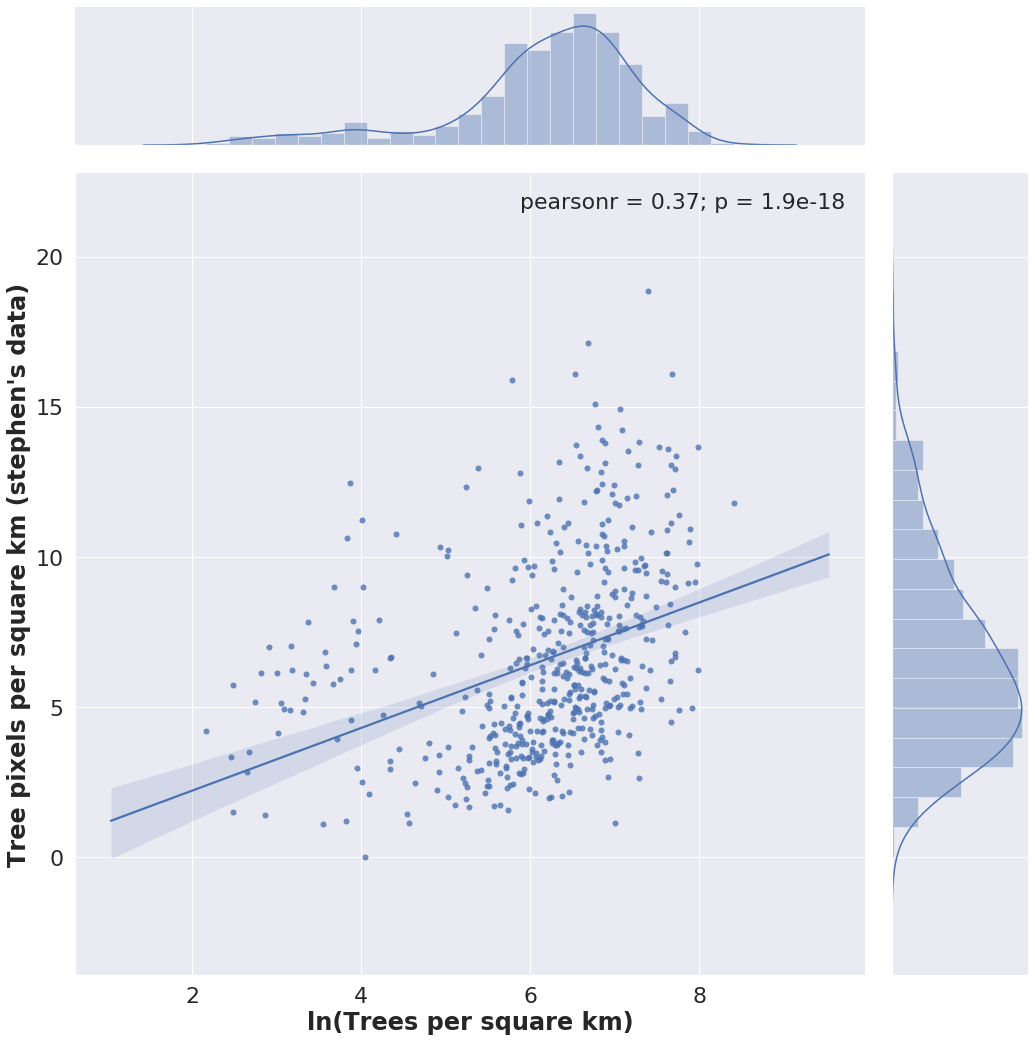

In [669]:
corr = pearsonr(gdf['TreeDensity'],gdf['TreePixelDensity'])
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=gdf,kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km (stephen\'s data)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

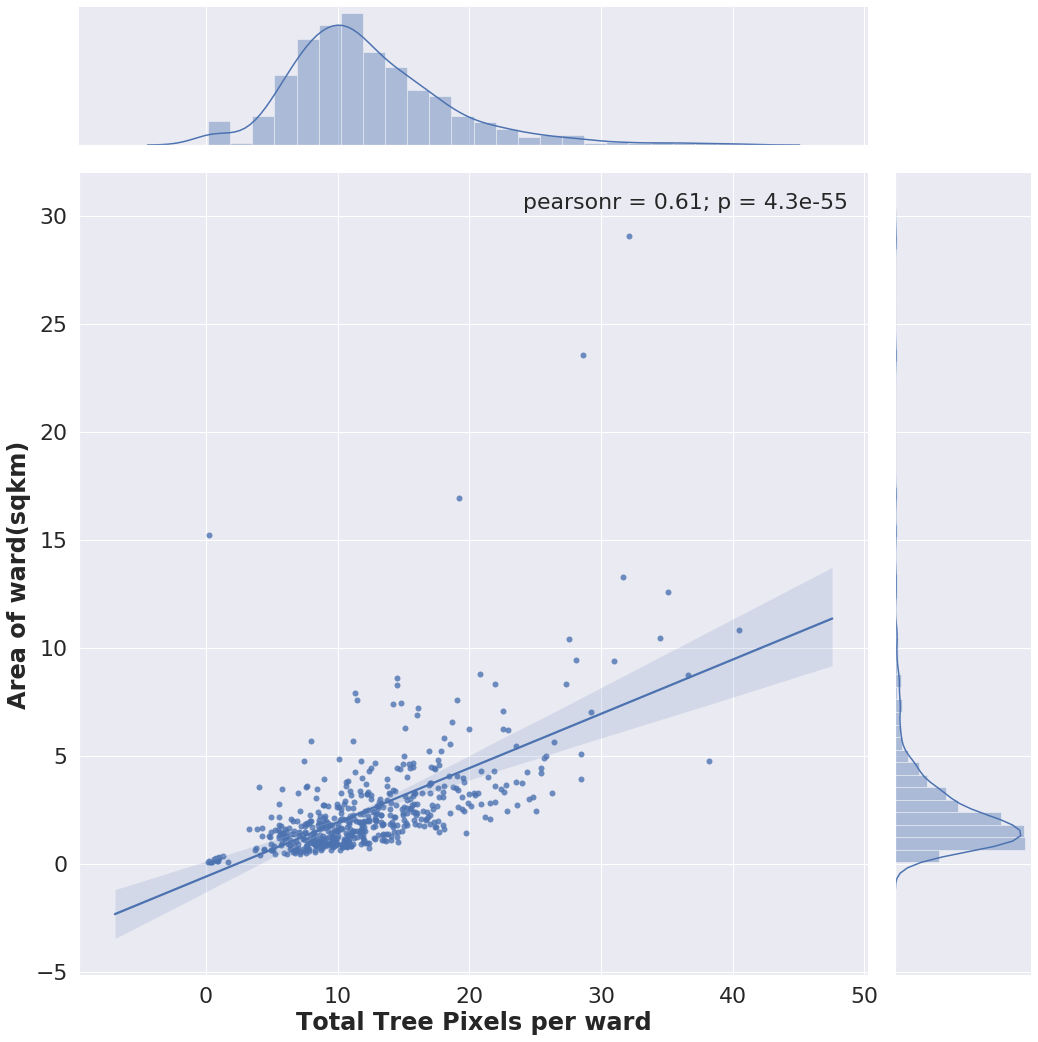

In [670]:
corr = pearsonr(gdf['TreeTotal'],gdf['area_km']/10)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=gdf['TreeTotal'], y=gdf['area_km']/10,kind='regression',height=15);
plt.xlabel('Total Tree Pixels per ward')
plt.ylabel('Area of ward(sqkm)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [671]:
corrs = []
bins = []
for name, group in gdf.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['AccessTreeDensity'],group['TreePixelDensity'])
    corrs.append(corr)

In [672]:
corrs

[(0.4733584673102313, 0.00022912958847303103),
 (0.09853358729556955, 0.48708201474857926),
 (0.25494121617351945, 0.06032131756698847),
 (0.06268428553703301, 0.6462642554232731),
 (0.017357753672575388, 0.9067833293097686),
 (0.22548186901511674, 0.09474363045409587),
 (0.348231672576766, 0.012274835838236475),
 (0.3341419819896133, 0.011075677863002316),
 (0.37398563402695284, 0.008117667688427345),
 (0.45321117338918543, 0.0005786362300306225)]

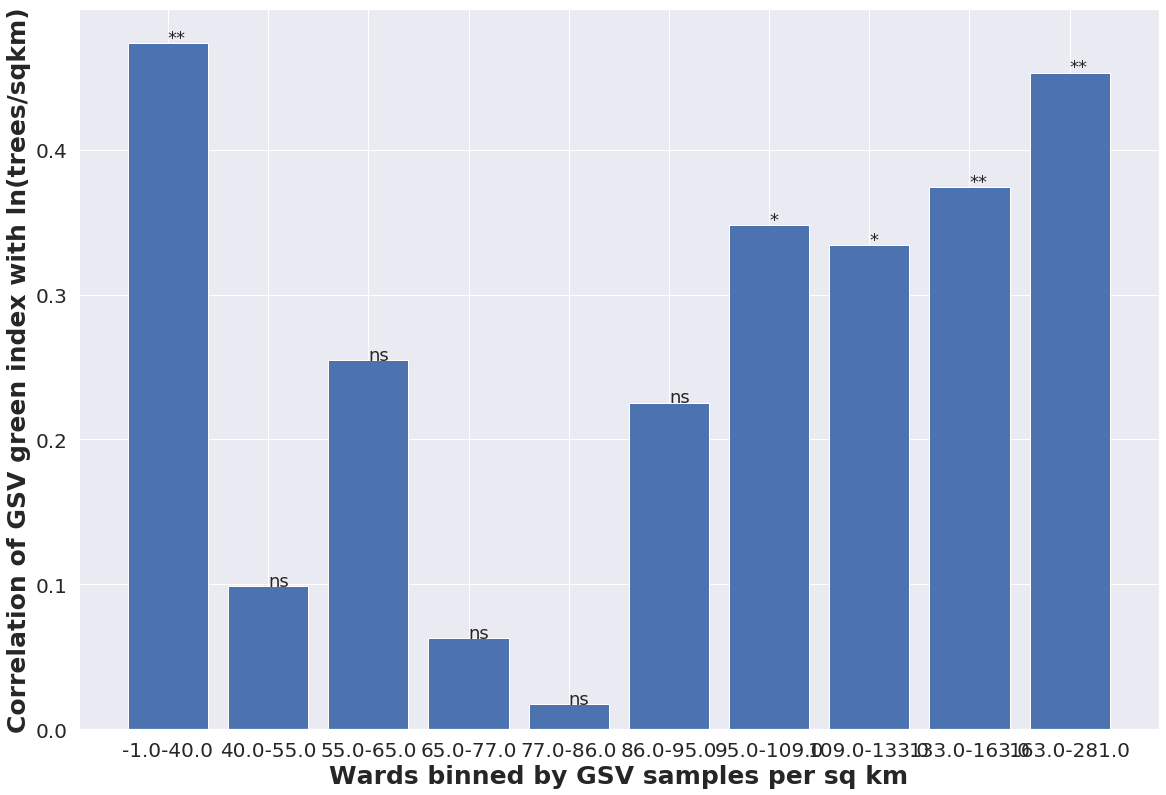

In [673]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by GSV samples per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [674]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['borough_name'], xy=(r["AccessTreeDensity"], r["TreePixelDensity"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

In [675]:
# corrs_density = []
# bins_density = []
# for name, group in gdf.groupby('decile_treeDensity'):
#     bins_density.append(name)
#     corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])
#     sns.set(font_scale=2) 
#     ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=group,kind='regression',height=15);
#     plt.xlabel('ln(Trees per square km)')
#     plt.ylabel('Tree pixels per square km')
#     ax.annotate(pearsonr)
#     for row in group.iterrows():
#         ann(row)
#     corrs_density.append(corr)

In [676]:
corrs_density

[(0.4424150380802104, 0.0005065049426999888),
 (-0.06444009806770845, 0.6339111869231814),
 (0.04015582599337324, 0.7647255589921684),
 (0.06280305209467488, 0.6425713785908369),
 (0.05427966559504949, 0.6857117267379165),
 (0.08152494480994134, 0.5465961390312346),
 (0.08364885873155586, 0.5361605803618947),
 (0.13275343566506131, 0.32050675002822715),
 (0.21923358454206254, 0.10131567267371829),
 (0.019258619490856804, 0.8859034288944954)]

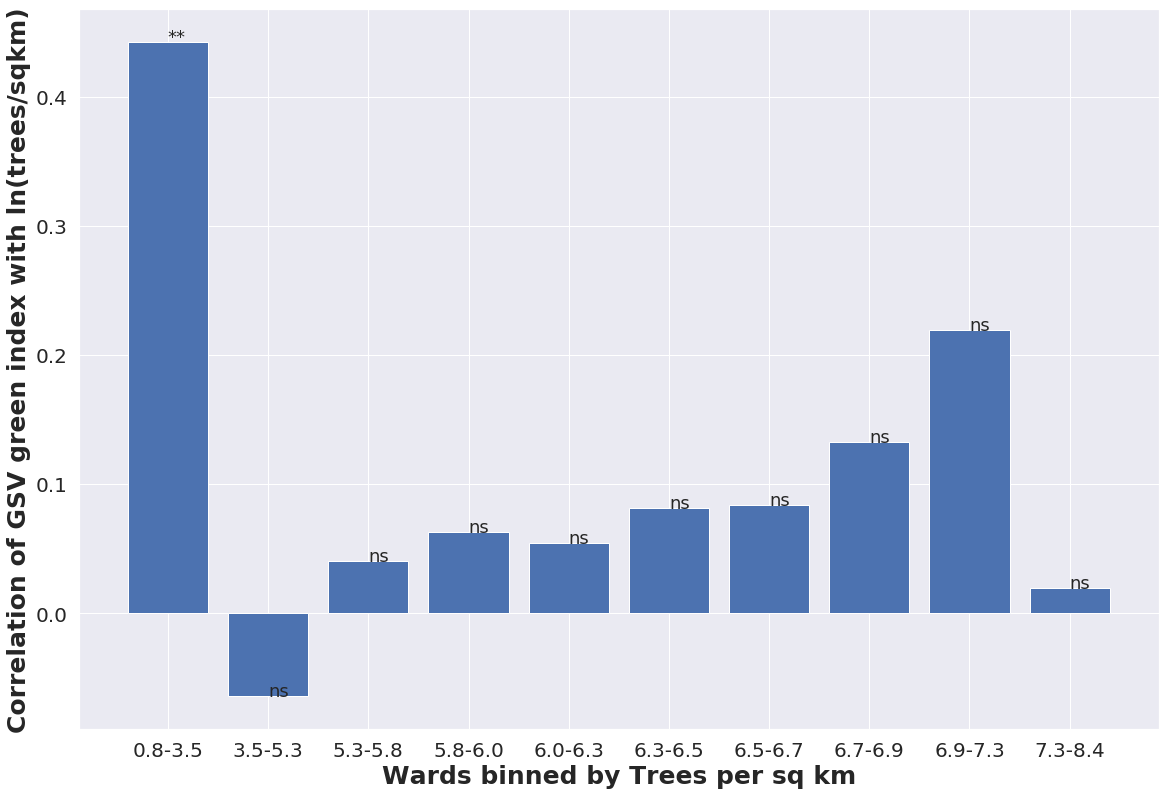

In [677]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Trees per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)[:5]+'-'+str(b.right)[:5] for b in bins_density]
c = [corr[0] for corr in corrs_density]
ax.bar(xlabels,c)

p = []
for corr in corrs_density: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [678]:
wardpop = pd.read_csv('../Data/Geo_Data/housing-density-ward.csv')

In [679]:
wardpop = wardpop.rename(columns={'Code': 'borough_name'})

In [680]:
wardpop = wardpop[wardpop['Year']==2011]

In [681]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')

In [682]:
ward_frame.head()

NAME AREA_CODE           DESCRIPTIO  \
0       Chessington South Ward       LBW  London Borough Ward   
1  Tolworth and Hook Rise Ward       LBW  London Borough Ward   
2              Berrylands Ward       LBW  London Borough Ward   
3               Alexandra Ward       LBW  London Borough Ward   
4                Beverley Ward       LBW  London Borough Ward   

                  FILE_NAME  NUMBER  NUMBER0  POLYGON_ID  UNIT_ID       CODE  \
0  GREATER_LONDON_AUTHORITY      52      733       50840    10884  E05000405   
1  GREATER_LONDON_AUTHORITY     106      734      117160    11407  E05000414   
2  GREATER_LONDON_AUTHORITY     107      735       50449    11413  E05000401   
3  GREATER_LONDON_AUTHORITY     108      736       50456    11420  E05000400   
4  GREATER_LONDON_AUTHORITY     109      737      117161    11417  E05000402   

   HECTARES  AREA TYPE_CODE          DESCRIPT0 TYPE_COD0 DESCRIPT1  \
0   755.173   0.0        VA  CIVIL VOTING AREA      None      None   
1   259.464   0.0        VA  CIVIL VOTING AREA      None      None   
2   145.390   0.0        VA  CIVIL VOTING AREA      None      None   
3   268.506   0.0        VA  CIVIL VOTING AREA      None      None   
4   187.821   0.0        VA  CIVIL VOTING AREA      None      None   

                                            geometry  
0  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...  
1  POLYGON ((-0.30846 51.37586, -0.30834 51.37606...  
2  POLYGON ((-0.30385 51.39249, -0.30375 51.39252...  
3  POLYGON ((-0.26990 51.38845, -0.26975 51.38838...  
4  POLYGON ((-0.24662 51.39921, -0.24672 51.39921...

In [683]:
len(ward_frame)

649

In [684]:
population = wardpop[['borough_name','Population','Population_per_square_kilometre','Ward_Name']]

In [685]:
population_stats = pd.DataFrame.merge(ward_frame,population,left_on='CODE',right_on='borough_name',how='outer')

In [686]:
len(population_stats)

649

In [687]:
population_stats.to_csv('Ward_stats.csv')

In [688]:
tree = {}
tree_density = {}
tree_pixel_density = {}
pop_density = {}
pop = {}
names = []
for index, row in gdf.iterrows():
    wardname = row['borough_name']
    names.append(wardname)
    tree_density[wardname] = row['AccessTreeDensity']
    tree[wardname] = row['AccessibleTreeCount']
    tree_pixel_density[wardname] = row['TreePixelDensity']
    
for index,row in wardpop.iterrows():
    pop_density[row['borough_name']] = np.log10(row['Population_per_square_kilometre'])
    pop[row['borough_name']] = row['Population']
    
common =  set(wardpop['borough_name']).intersection(names)
        

In [689]:
# tree

In [690]:
# pop

In [691]:
tree_to_people_ratio = {} 
for k in pop:
    if k in tree:
        tree_to_people_ratio[k] = float(tree[k])/float(pop[k])

In [692]:
vals = np.log10(list(tree_to_people_ratio.values()))
thresh_low = np.mean(vals) - np.sqrt(np.var(vals))
thresh_high = np.mean(vals) + np.sqrt(np.var(vals))

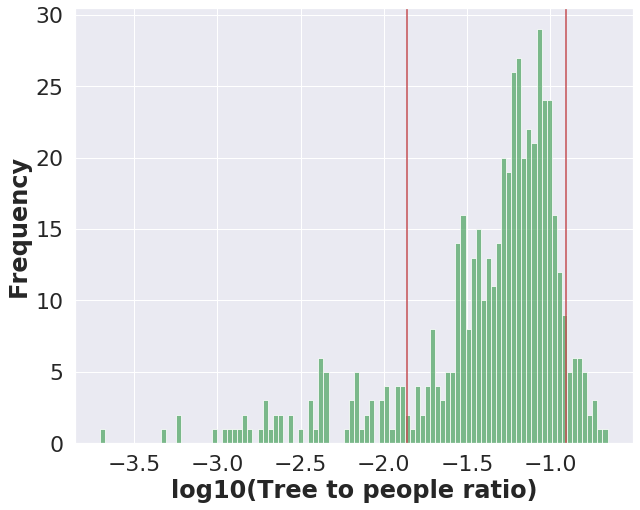

In [693]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(list(tree_to_people_ratio.values())), 100, facecolor='g', alpha=0.75)

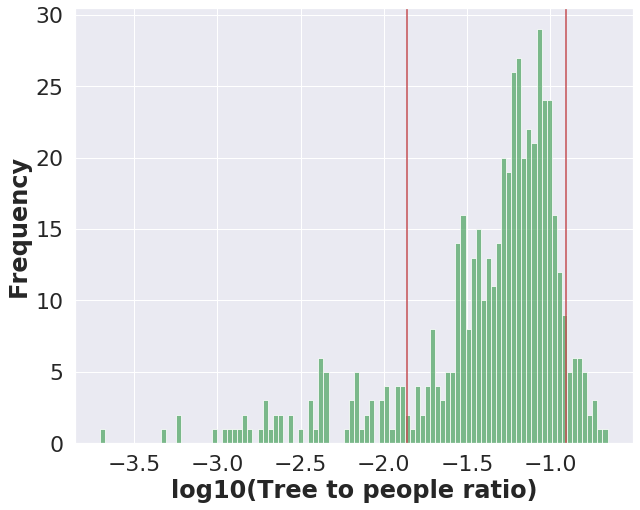

In [694]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(list(tree_to_people_ratio.values())), 100, facecolor='g', alpha=0.75)

In [695]:
filteredCommon = [k for k in common if np.log10(tree_to_people_ratio[k]) < thresh_high and  np.log10(tree_to_people_ratio[k]) > thresh_low ]

# The correlation of trees planted and the GSV trees is highest in the areas where the tee to people ratio is above 1

In [696]:
print ([k for k in common if np.log10(tree_to_people_ratio[k]) > thresh_high or  np.log10(tree_to_people_ratio[k]) < thresh_low ])

['E05000628', 'E05000404', 'E05000621', 'E05000512', 'E05000270', 'E05000126', 'E05000505', 'E05000507', 'E05000317', 'E05000120', 'E05000501', 'E05000122', 'E05000333', 'E05000348', 'E05000467', 'E05000052', 'E05000406', 'E05000158', 'E05000506', 'E05000071', 'E05000514', 'E05000038', 'E05000473', 'E05000559', 'E05000461', 'E05000307', 'E05000155', 'E05000594', 'E05000582', 'E05000508', 'E05000442', 'E05000510', 'E05000365', 'E05000100', 'E05000173', 'E05000400', 'E05000168', 'E05000153', 'E05000414', 'E05000278', 'E05000557', 'E05000516', 'E05000079', 'E05000513', 'E05000283', 'E05000448', 'E05000247', 'E05000238', 'E05000614', 'E05000239', 'E05000618', 'E05000065', 'E05000149', 'E05000192', 'E05000509', 'E05000439', 'E05000613', 'E05000499', 'E05000159', 'E05000308', 'E05000236', 'E05000163', 'E05000622', 'E05000110', 'E05000503', 'E05000445', 'E05000405', 'E05000167', 'E05000517', 'E05000602', 'E05000554', 'E05000127', 'E05000627', 'E05000119', 'E05000497', 'E05000099', 'E05000464'

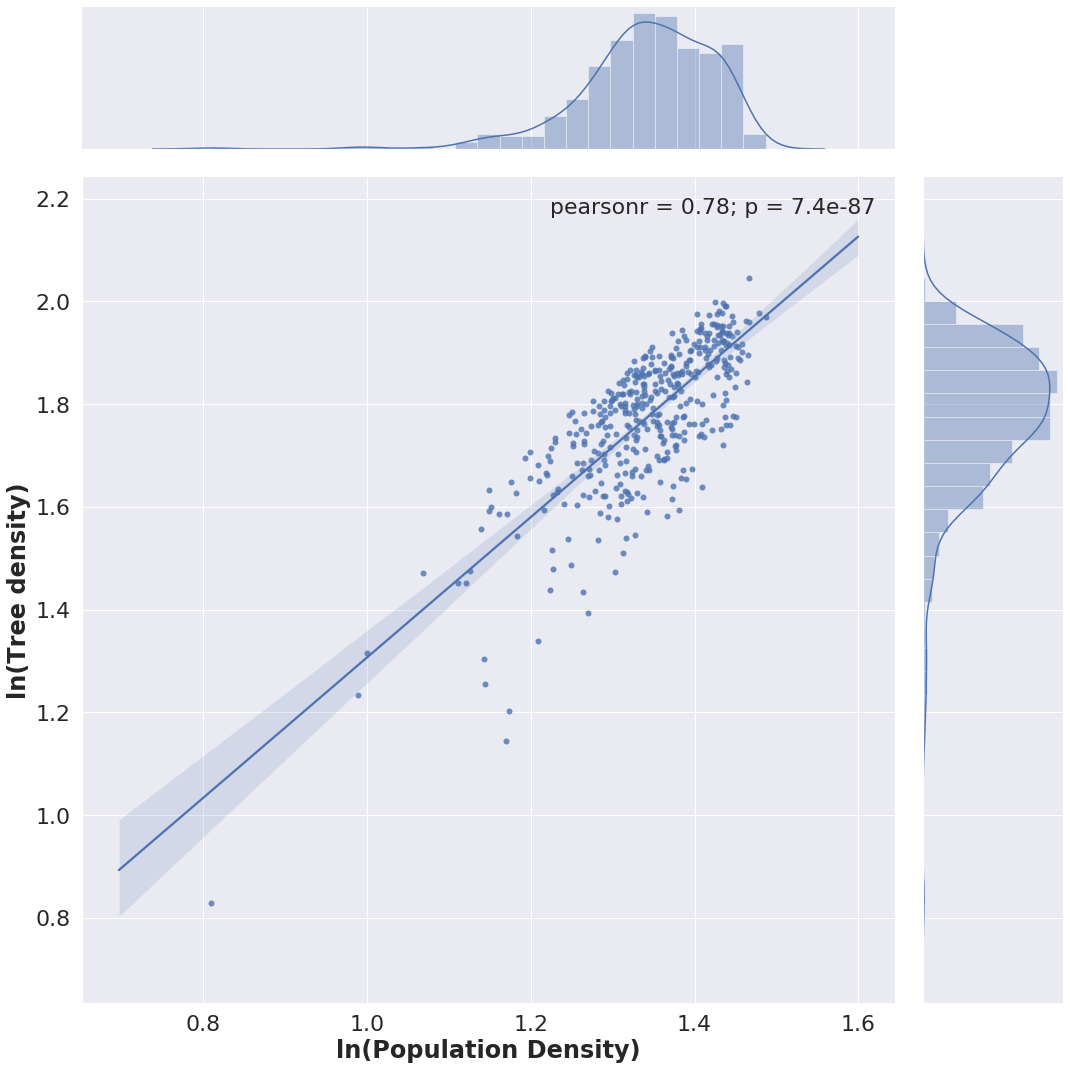

In [697]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(pop_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Population Density)')
plt.ylabel('ln(Tree density)')
ax.annotate(pearsonr)

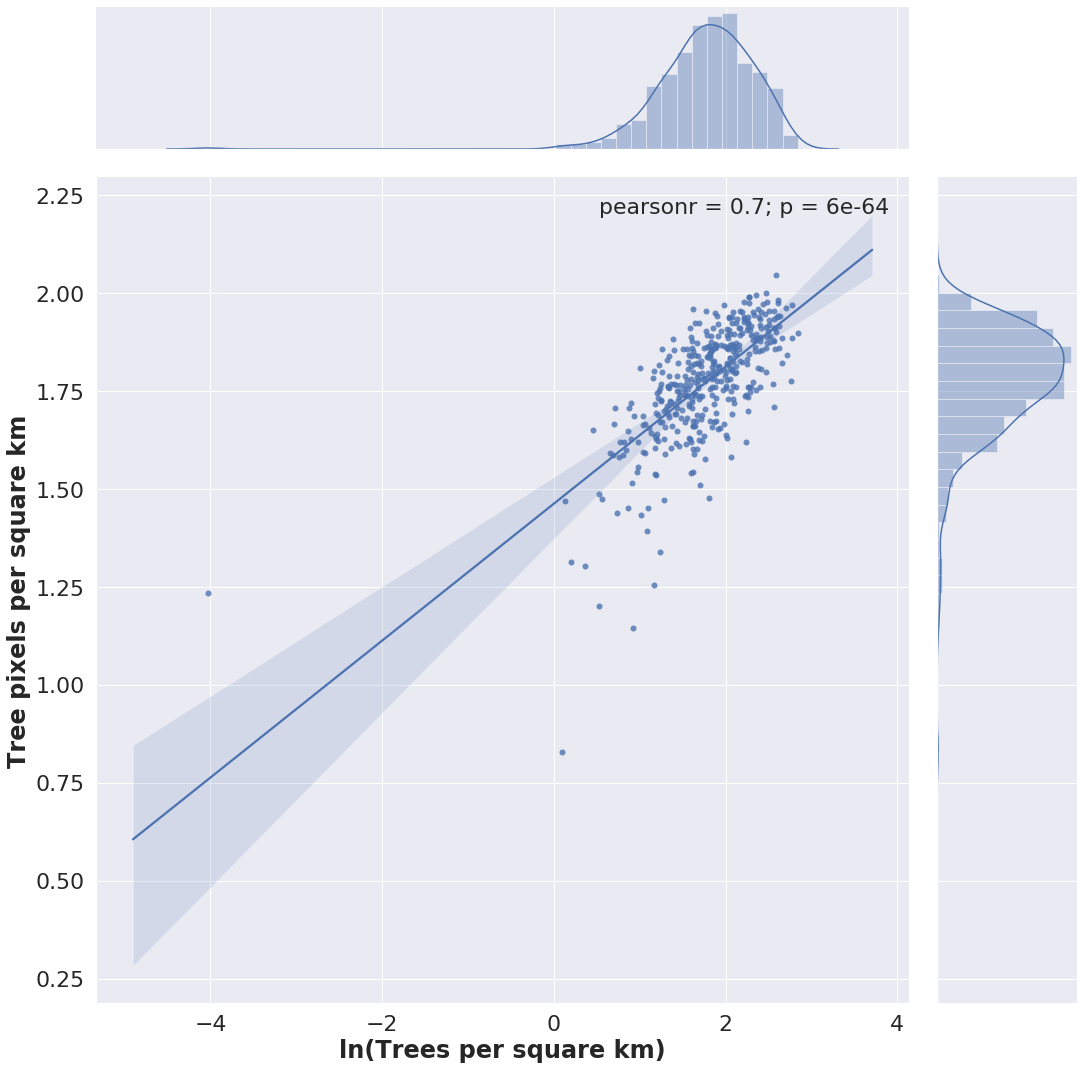

In [698]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(tree_pixel_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km')
ax.annotate(pearsonr)

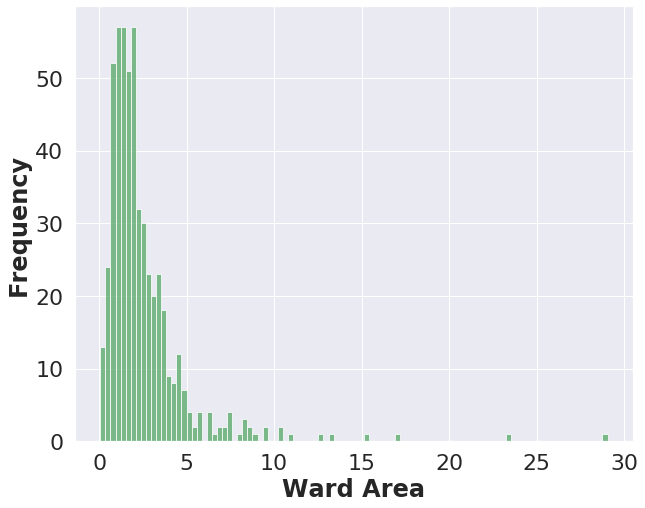

In [699]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Ward Area')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10.0, 100, facecolor='g', alpha=0.75)

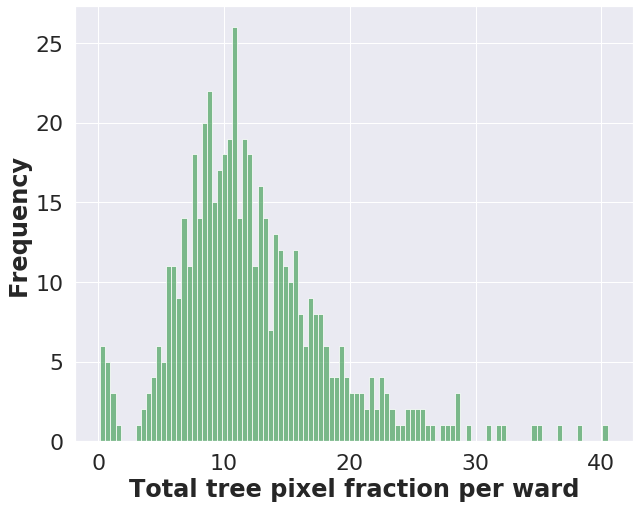

In [700]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Total tree pixel fraction per ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeTotal'], 100, facecolor='g', alpha=0.75)

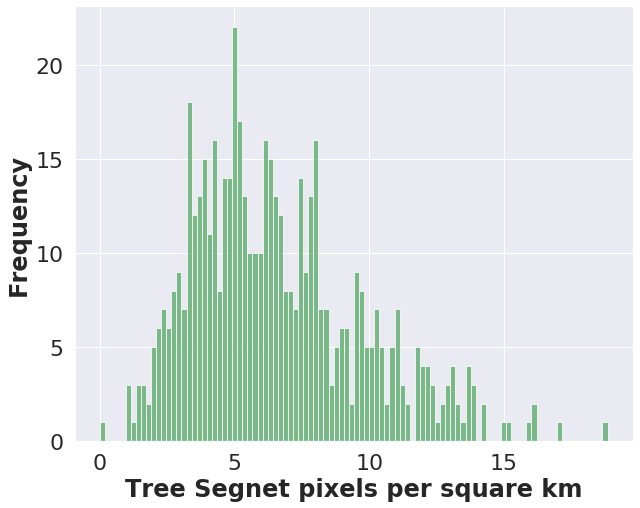

In [701]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Tree Segnet pixels per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

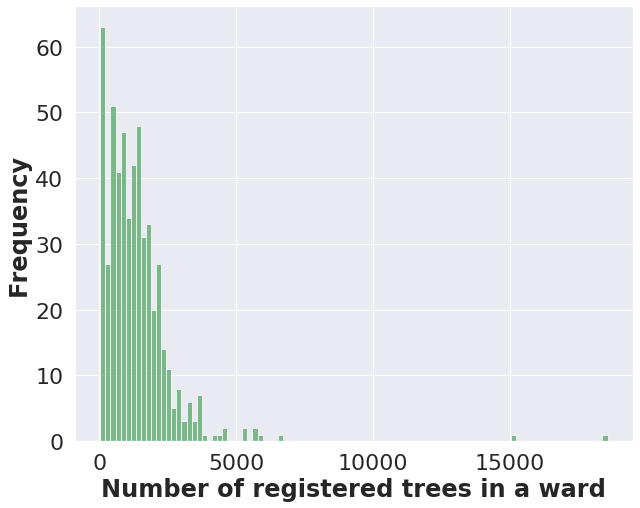

In [702]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeCount'], 100, facecolor='g', alpha=0.75)

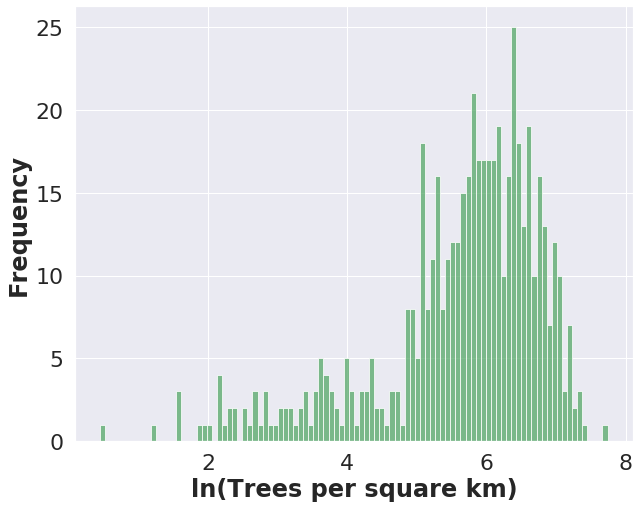

In [703]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['AccessTreeDensity'], 100, facecolor='g', alpha=0.75)

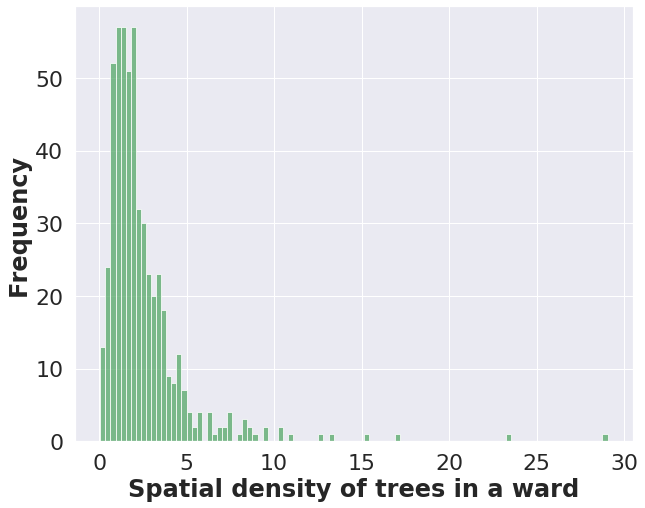

In [704]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Spatial density of trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10, 100, facecolor='g', alpha=0.75)

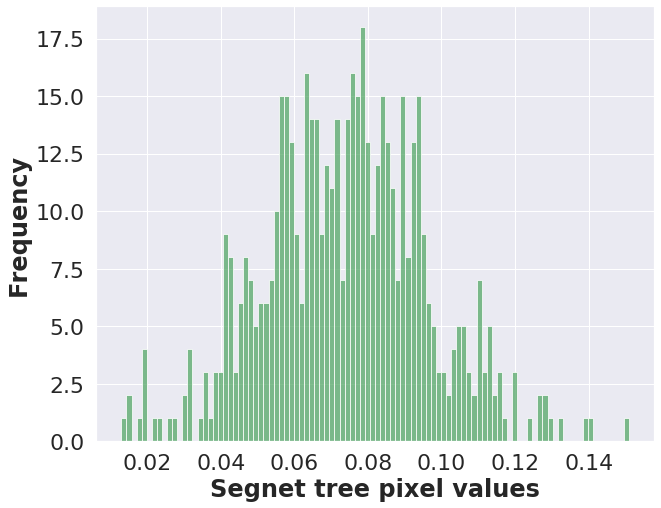

In [705]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['Tree'], 100, facecolor='g', alpha=0.75)

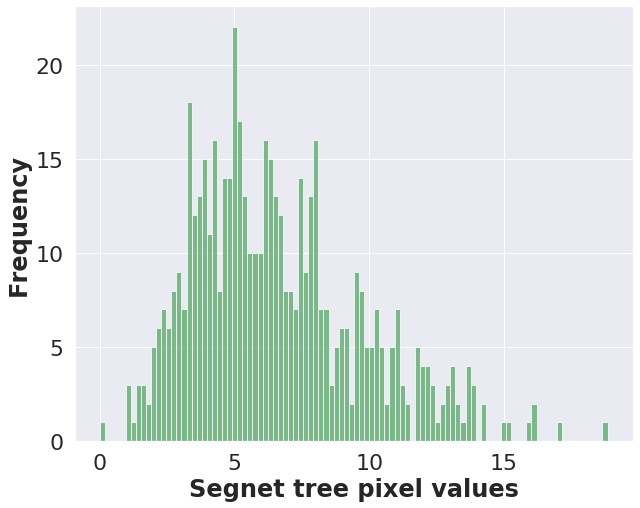

In [706]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

In [707]:
min(gdf['AccessTreeDensity'])

0.4497795758982637

In [708]:
#Work with merging wards 
Wards_LSOA_2001 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2001_Lookup_in_England_and_Wales.csv')
Wards_LSOA_2011 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2011_Lookup_in_England_and_Wales.csv')

In [709]:
merged_Wards_LSOA = pd.merge(Wards_LSOA_2001, Wards_LSOA_2011, on='LSOA01CD', how='outer')

In [710]:
# merged_Wards_LSOA.to_csv('Merged_wards_LSOA_2001_2011.csv')
merged_Wards_LSOA.head()

LSOA01CD                 LSOA01NM_x  WD01CD           WD01NM  FID_x  \
0  E01012101  Redcar and Cleveland 001B  00EEMC          Coatham  12001   
1  E01012351            Darlington 004C  00EHMW       North Road  12002   
2  E01012102  Redcar and Cleveland 001C  00EEMC          Coatham  12003   
3  E01012352            Darlington 004D  00EHMW       North Road  12004   
4  E01012353            Darlington 008B  00EHMU  Northgate South  12005   

                  LSOA01NM_y     WD11CD WD11CDO      WD11NM  FID_y  
0  Redcar and Cleveland 001B  E05001506  00EENA     Coatham  12019  
1            Darlington 004C  E05001571  00EHNX  North Road  12008  
2  Redcar and Cleveland 001C  E05001506  00EENA     Coatham  12023  
3            Darlington 004D  E05001571  00EHNX  North Road  12010  
4            Darlington 008B  E05001572  00EHNY   Northgate  12011

In [711]:
ward_csv_CRESH = pd.read_csv('../Data/Geo_Data/uk_ward_greenspace.csv')

In [712]:
ward_csv_CRESH.head()

casward2001  greenspace_pc
0      00AAFA       8.383184
1      00AAFE      24.354640
2      00AAFQ      10.795210
3      00AAFS      22.745890
4      00AAFT      22.767050

In [713]:
WardMap = {}
for index , row in merged_Wards_LSOA.iterrows():
    WardMap[row['WD11CDO']] = row['WD11CD']

In [714]:
len(WardMap)

8541

In [715]:
# json.dump(WardMap , open("CAS_NEW_WARD_MAPPING.json",'w'))

In [716]:
len(set(ward_csv_CRESH['casward2001']).intersection(list(merged_Wards_LSOA['WD11CDO'])))

6492

In [717]:
MedIx_score_wards = {}
for index,row in ward_csv_CRESH.iterrows():
    old = row ['casward2001']
    if old in WardMap:
        MedIx_score_wards[WardMap[old]] = row['greenspace_pc']

In [718]:
MedIx_score_wards

{'E05000001': 8.383184,
 'E05000015': 10.79521,
 'E05000021': 17.16018,
 'E05000026': 15.685620000000002,
 'E05000027': 24.04374,
 'E05000028': 18.21998,
 'E05000029': 56.84335,
 'E05000030': 58.17402,
 'E05000031': 19.18874,
 'E05000032': 13.779910000000001,
 'E05000033': 14.4604,
 'E05000034': 40.23384,
 'E05000035': 29.751509999999996,
 'E05000036': 42.36457,
 'E05000037': 24.67846,
 'E05000038': 42.90501,
 'E05000039': 53.80516,
 'E05000040': 20.13458,
 'E05000041': 50.89484,
 'E05000042': 29.498559999999998,
 'E05000043': 19.94054,
 'E05000044': 14.8701,
 'E05000045': 26.283559999999998,
 'E05000046': 17.68908,
 'E05000047': 18.65261,
 'E05000048': 40.46021,
 'E05000049': 37.2539,
 'E05000050': 57.164640000000006,
 'E05000051': 18.5158,
 'E05000052': 25.74407,
 'E05000053': 22.36515,
 'E05000054': 50.030879999999996,
 'E05000055': 24.45143,
 'E05000056': 60.06723,
 'E05000057': 57.10446999999999,
 'E05000058': 21.5744,
 'E05000059': 60.85955,
 'E05000060': 47.09506,
 'E05000061': 

In [719]:
# %store MedIx_score_wards

In [720]:
# json.dump(MedIx_score_wards,open('Ward_index_deprivation.json','wb'))

In [734]:
GLUD_green = pd.read_csv('scratchpad/satellite_borne_green_indices_percent.csv')
len(GLUD_green)

483

In [722]:
GLUD_green.head()

WD17CD  GLUD_Area of Greenspace PCT  LCM_grass_pct  LCM_tree_pct  \
0  E05000026                     0.199622       0.024752      0.009194   
1  E05000027                     0.229128       0.138156      0.000000   
2  E05000028                     0.058343       0.122918      0.000000   
3  E05000029                     0.741304       0.185813      0.004209   
4  E05000030                     0.459967       0.292064      0.030131   

   LCM_urban_pct  UA_Public Greenery PCT  UA_Forests PCT  StreetTrees_PCT  
0       0.932815                0.064844             0.0         0.034379  
1       0.858260                0.256912             0.0         0.068538  
2       0.876416                0.157805             0.0         0.047912  
3       0.423620                0.046093             0.0         0.174167  
4       0.577416                0.459714             0.0         0.072611

In [723]:
MedixDf = pd.DataFrame.from_dict(MedIx_score_wards,orient='index')
MedixDf['GSS_CODE'] = MedixDf.index
MedixDf = MedixDf.rename(columns={0: 'green_score'})

In [736]:
MedixDf.head()

green_score   GSS_CODE
E05000001     8.383184  E05000001
E05000015    10.795210  E05000015
E05000021    17.160180  E05000021
E05000026    15.685620  E05000026
E05000027    24.043740  E05000027

In [725]:
len(MedixDf)

6492

In [726]:
MergedGLUD = pd.merge(MedixDf, GLUD_green, left_on='GSS_CODE' , right_on='WD17CD')

In [733]:
len(MergedGLUD)

483

In [727]:
MergedGLUD.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0     15.68562  E05000026  E05000026                     0.199622   
1     24.04374  E05000027  E05000027                     0.229128   
2     18.21998  E05000028  E05000028                     0.058343   
3     56.84335  E05000029  E05000029                     0.741304   
4     58.17402  E05000030  E05000030                     0.459967   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.024752      0.009194       0.932815                0.064844   
1       0.138156      0.000000       0.858260                0.256912   
2       0.122918      0.000000       0.876416                0.157805   
3       0.185813      0.004209       0.423620                0.046093   
4       0.292064      0.030131       0.577416                0.459714   

   UA_Forests PCT  StreetTrees_PCT  
0             0.0         0.034379  
1             0.0         0.068538  
2             0.0         0.047912  
3             0.0         0.174167  
4             0.0         0.072611

In [732]:
Merged_gpd_GLUD = pd.merge(ward_frame , MergedGLUD, left_on='CODE',right_on='GSS_CODE')
len(Merged_gpd_GLUD)

483

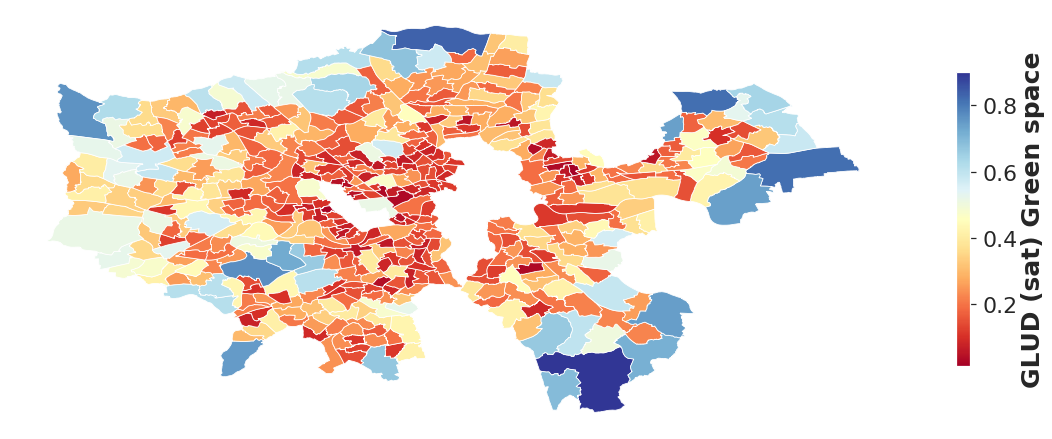

In [750]:
fig, ax = plt.subplots()
fig.set_size_inches(20,18)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=Merged_gpd_GLUD['GLUD_Area of Greenspace PCT'].min(), vmax=Merged_gpd_GLUD['GLUD_Area of Greenspace PCT'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('GLUD (sat) Green space', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
Merged_gpd_GLUD[Merged_gpd_GLUD['GLUD_Area of Greenspace PCT']!=0.0].plot(ax=ax,column='GLUD_Area of Greenspace PCT', cmap='RdYlBu', linewidth=0.8)

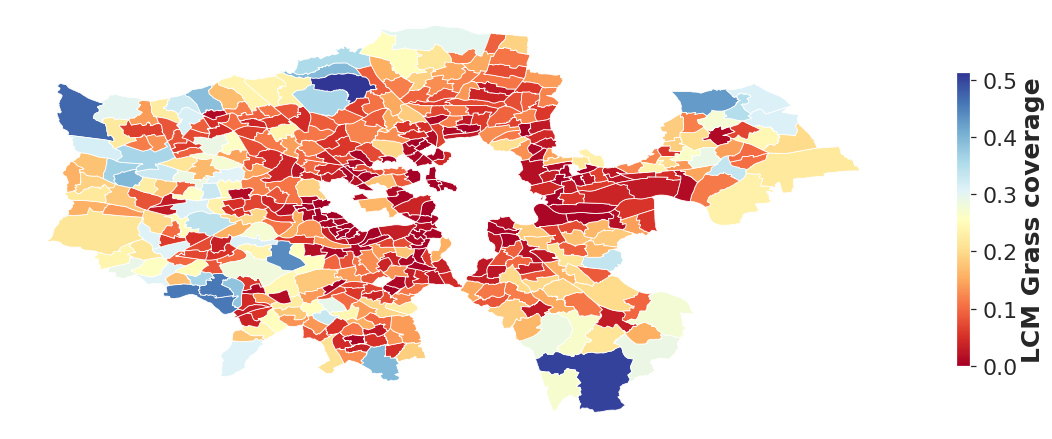

In [751]:
fig, ax = plt.subplots()
fig.set_size_inches(20,18)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=Merged_gpd_GLUD['LCM_grass_pct'].min(), vmax=Merged_gpd_GLUD['LCM_grass_pct'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('LCM Grass coverage', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
Merged_gpd_GLUD[Merged_gpd_GLUD['LCM_grass_pct']!=0.0].plot(ax=ax,column='LCM_grass_pct', cmap='RdYlBu', linewidth=0.8)

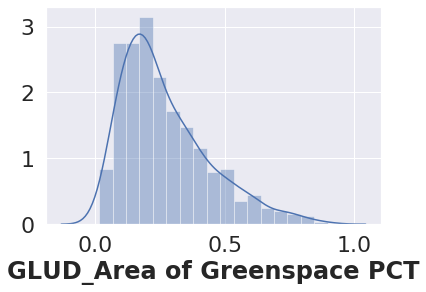

In [752]:
sns.distplot(Merged_gpd_GLUD['GLUD_Area of Greenspace PCT'])

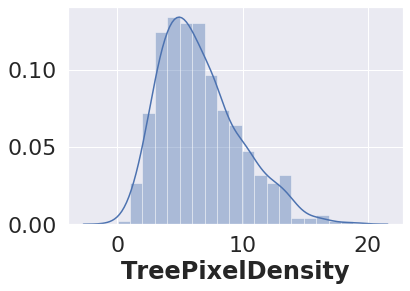

In [754]:
sns.distplot(gdf['TreePixelDensity'])

(0.7748603202474922, 7.236422420064563e-98)


Text(29, 0.25, 'Pearson r: 0.77***')

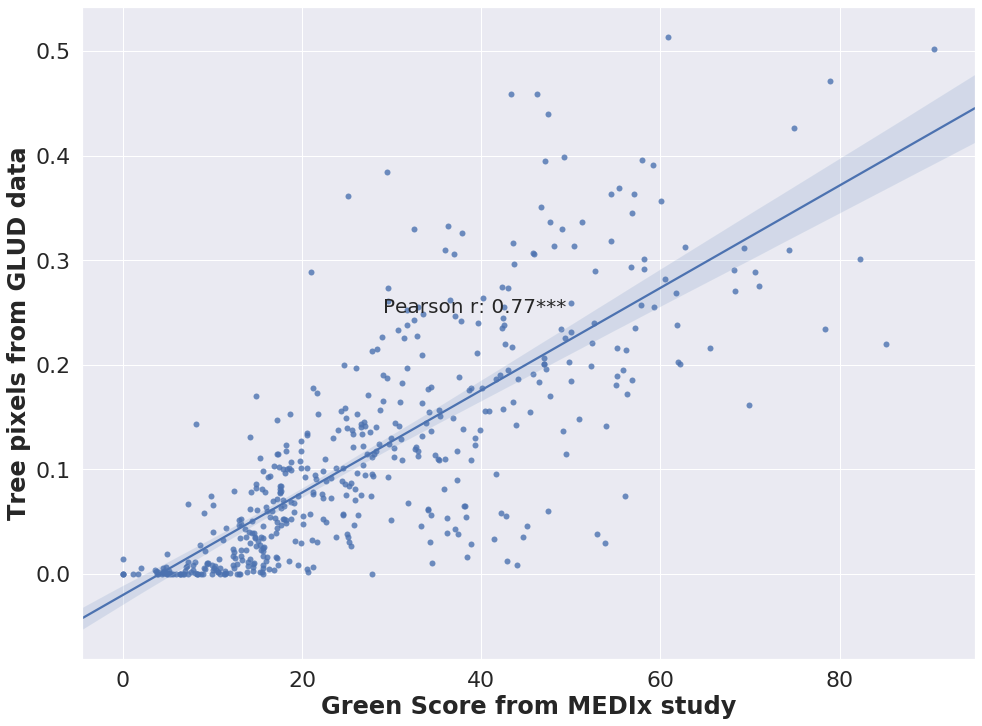

In [747]:
corr = pearsonr(MergedGLUD['green_score'],MergedGLUD['LCM_grass_pct'])
print (corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="green_score", y="LCM_grass_pct", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

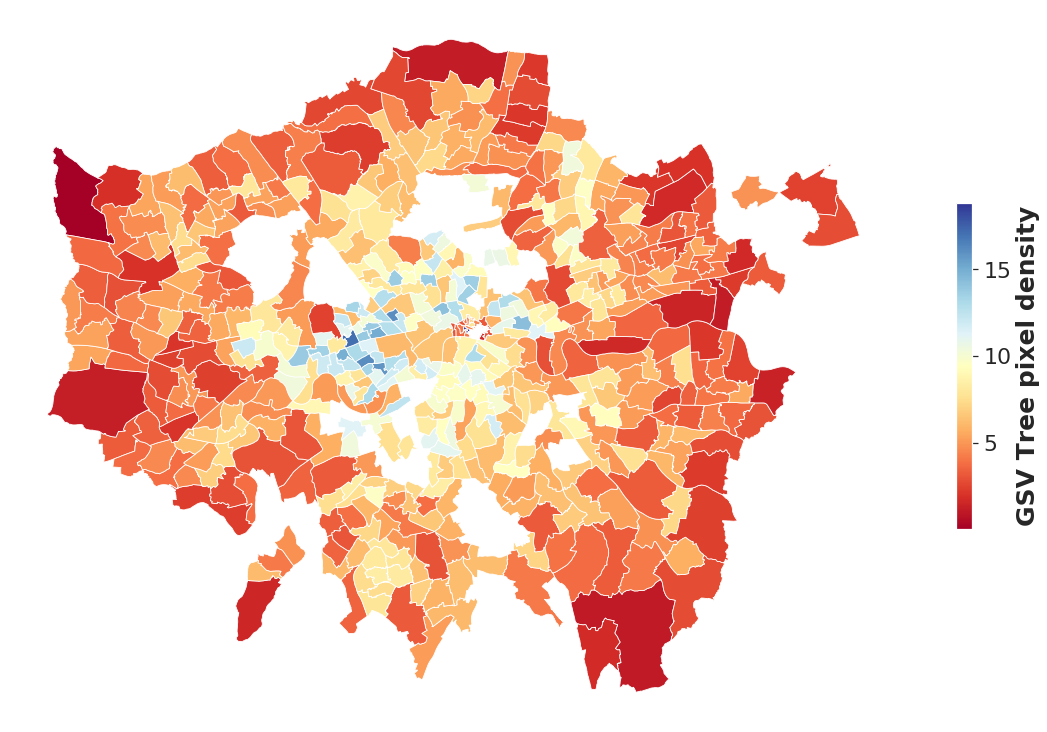

In [748]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=gdf['TreePixelDensity'].min(), vmax=gdf['TreePixelDensity'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('GSV Tree pixel density', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
gdf[gdf['TreePixelDensity']!=0.0].plot(ax=ax,column='TreePixelDensity', cmap='RdYlBu', linewidth=0.8)

In [578]:
# Df = pd.read_pickle('Ward_mapillary.pkl')

In [579]:
# Df.head()

In [580]:
# gdf_Df = gpd.GeoDataFrame(Df, geometry='poly', crs={'init': 'epsg:4326'})

In [755]:
gdf.columns

Index(['poly', 'borough_name', 'area_m', 'area_km', 'gsview_point_list',
       'gsview_segnet_tags_dict', 'gsview_tags', 'total_gsview_pixels', 'Tree',
       'TreeTotal', 'samples', 'TreeScore_norm', 'Tree_location_list',
       'TreeCount', 'Accessible_Tree_location_list', 'AccessibleTreeCount',
       'InAccessible_Tree_location_list', 'InaccessibleTreeCount',
       'NormedTreeCount', 'NormedTreeSegnet', 'TreeDensity',
       'AccessTreeDensity', 'InAccessTreeDensity', 'TreePixelDensity',
       'GSV_samples_per_sqkm', 'decile', 'decile_treeDensity'],
      dtype='object')

(0.45521142940680914, 1.1284846984080754e-28)


Text(29, 0.25, 'Pearson r: 0.45***')

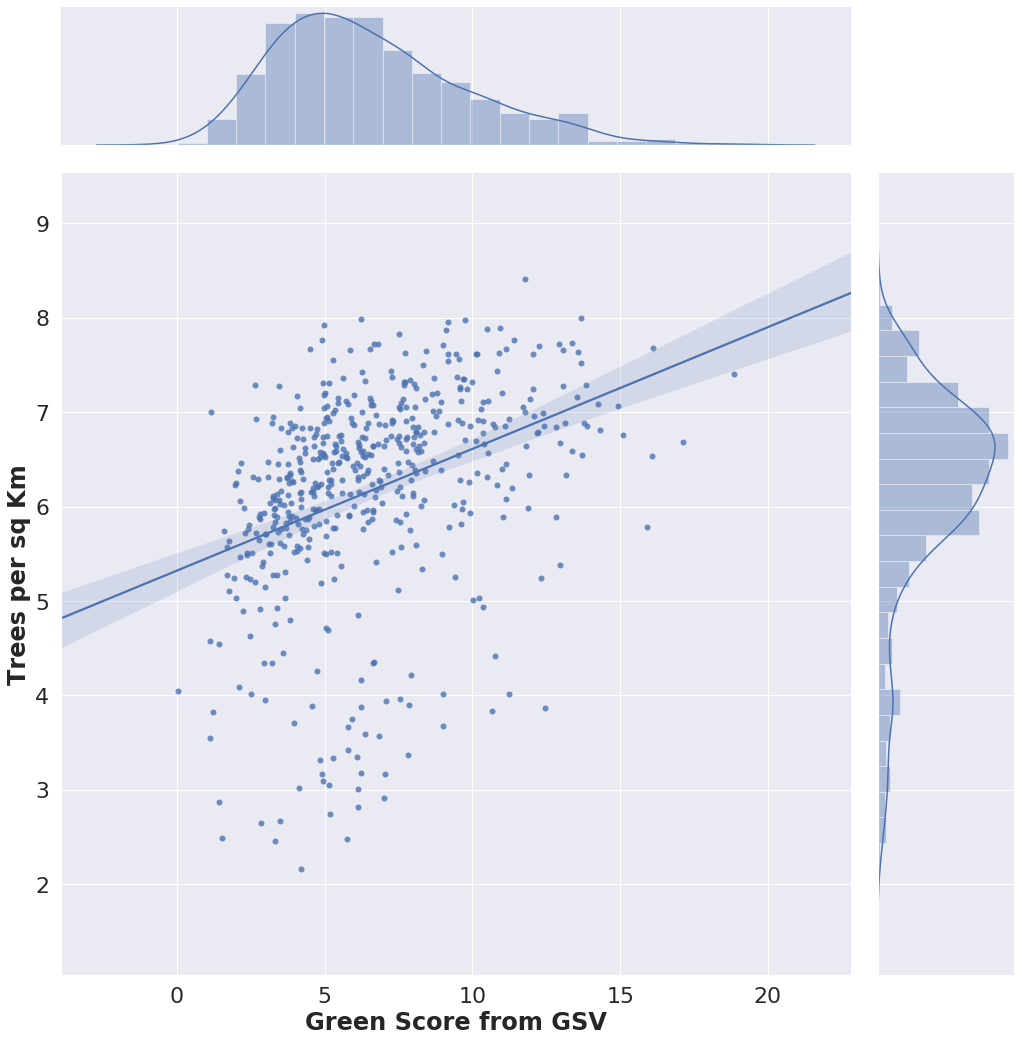

In [756]:
corr = pearsonr(gdf['TreePixelDensity'],gdf['AccessTreeDensity'])
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="TreePixelDensity", y="TreeDensity", data=gdf,kind='regression',height=15);
plt.xlabel('Green Score from GSV')
plt.ylabel('Trees per sq Km')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [757]:
GSV_TreeValue = gdf[['borough_name','TreePixelDensity','TreeDensity','AccessTreeDensity','InAccessTreeDensity']].copy()

In [758]:
merged_inner_GSV = pd.merge(left=Merged_gpd_GLUD,right=GSV_TreeValue, left_on='GSS_CODE', right_on='borough_name')

In [759]:
merged_inner_GSV.head()

NAME AREA_CODE           DESCRIPTIO  \
0           Chessington South Ward       LBW  London Borough Ward   
1      Tolworth and Hook Rise Ward       LBW  London Borough Ward   
2                   Alexandra Ward       LBW  London Borough Ward   
3                 Coombe Hill Ward       LBW  London Borough Ward   
4  Chessington North and Hook Ward       LBW  London Borough Ward   

                  FILE_NAME  NUMBER  NUMBER0  POLYGON_ID  UNIT_ID       CODE  \
0  GREATER_LONDON_AUTHORITY      52      733       50840    10884  E05000405   
1  GREATER_LONDON_AUTHORITY     106      734      117160    11407  E05000414   
2  GREATER_LONDON_AUTHORITY     108      736       50456    11420  E05000400   
3  GREATER_LONDON_AUTHORITY     118      738      117159    11423  E05000406   
4  GREATER_LONDON_AUTHORITY     308      739       50530    11406  E05000404   

   HECTARES  ...  LCM_tree_pct LCM_urban_pct UA_Public Greenery PCT  \
0   755.173  ...      0.178329      0.317174               0.024787   
1   259.464  ...      0.019305      0.729344               0.088869   
2   268.506  ...      0.086067      0.643386               0.360498   
3   442.170  ...      0.138631      0.606747               0.590407   
4   192.980  ...      0.015210      0.783197               0.037622   

  UA_Forests PCT StreetTrees_PCT borough_name  TreePixelDensity TreeDensity  \
0       0.364484        0.185421    E05000405          1.516892    2.488334   
1       0.000000        0.001693    E05000414          4.144974    3.016093   
2       0.000000        0.008077    E05000400          4.839140    3.315636   
3       0.000000        0.000779    E05000406          3.497838    2.671621   
4       0.000000        0.061207    E05000404          6.141798    3.005401   

  AccessTreeDensity  InAccessTreeDensity  
0          2.167130             1.414683  
1          3.140145             1.824620  
2          3.185958             2.193783  
3          2.383939             1.608316  
4          3.516227             0.971080  

[5 rows x 31 columns]

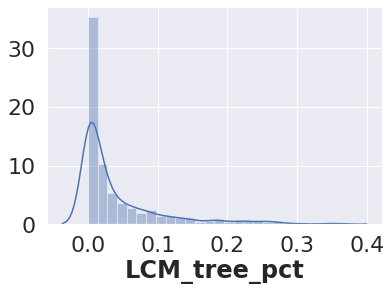

In [760]:
sns.distplot(merged_inner_GSV['LCM_tree_pct'])

(0.7771113751938645, 1.1485473465345231e-83)


Text(60, 20, 'Pearson r: 0.77***')

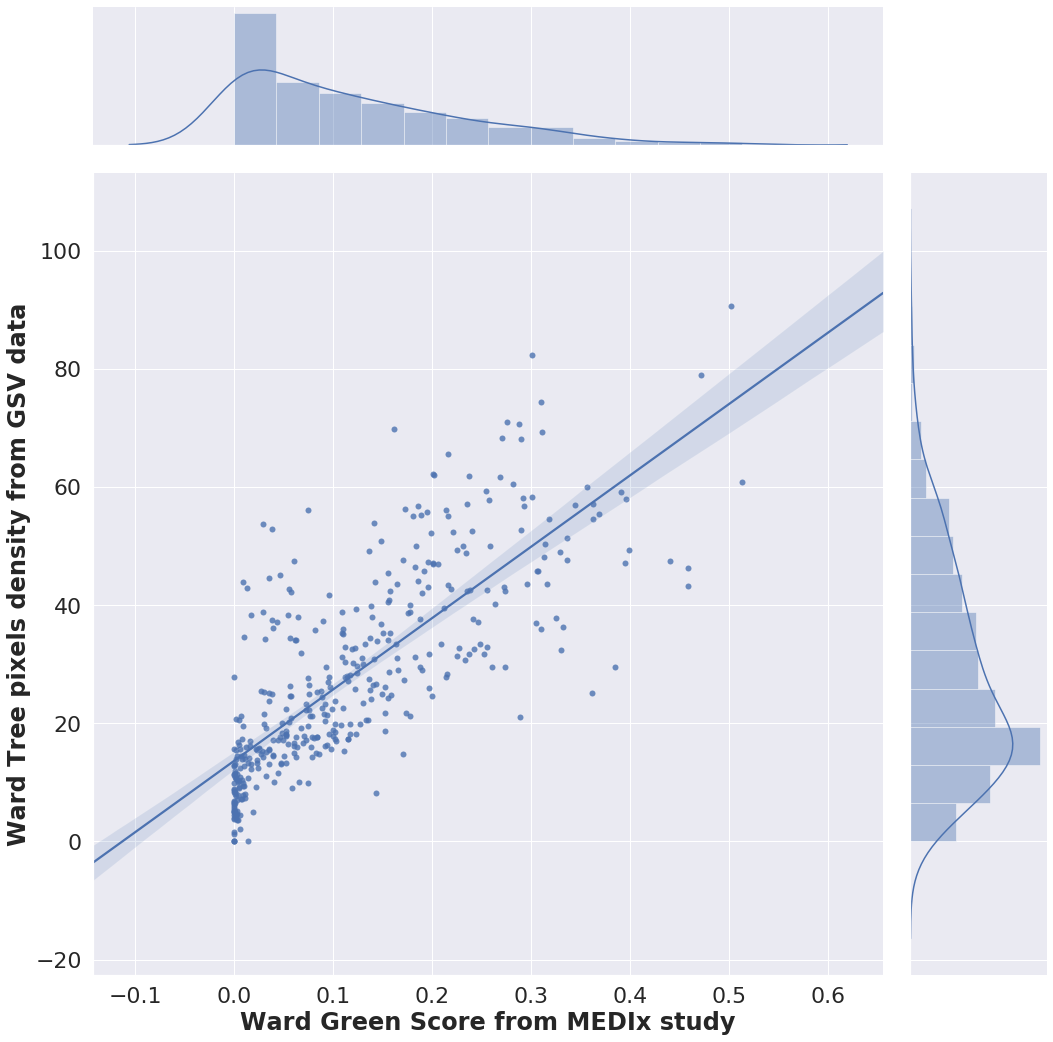

In [761]:
corr = pearsonr(merged_inner_GSV['LCM_grass_pct'],merged_inner_GSV['green_score'])
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="LCM_grass_pct", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Ward Green Score from MEDIx study')
plt.ylabel('Ward Tree pixels density from GSV data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(0.917475222584238, 1.2456104665855475e-164)


Text(60, 20, 'Pearson r: 0.91***')

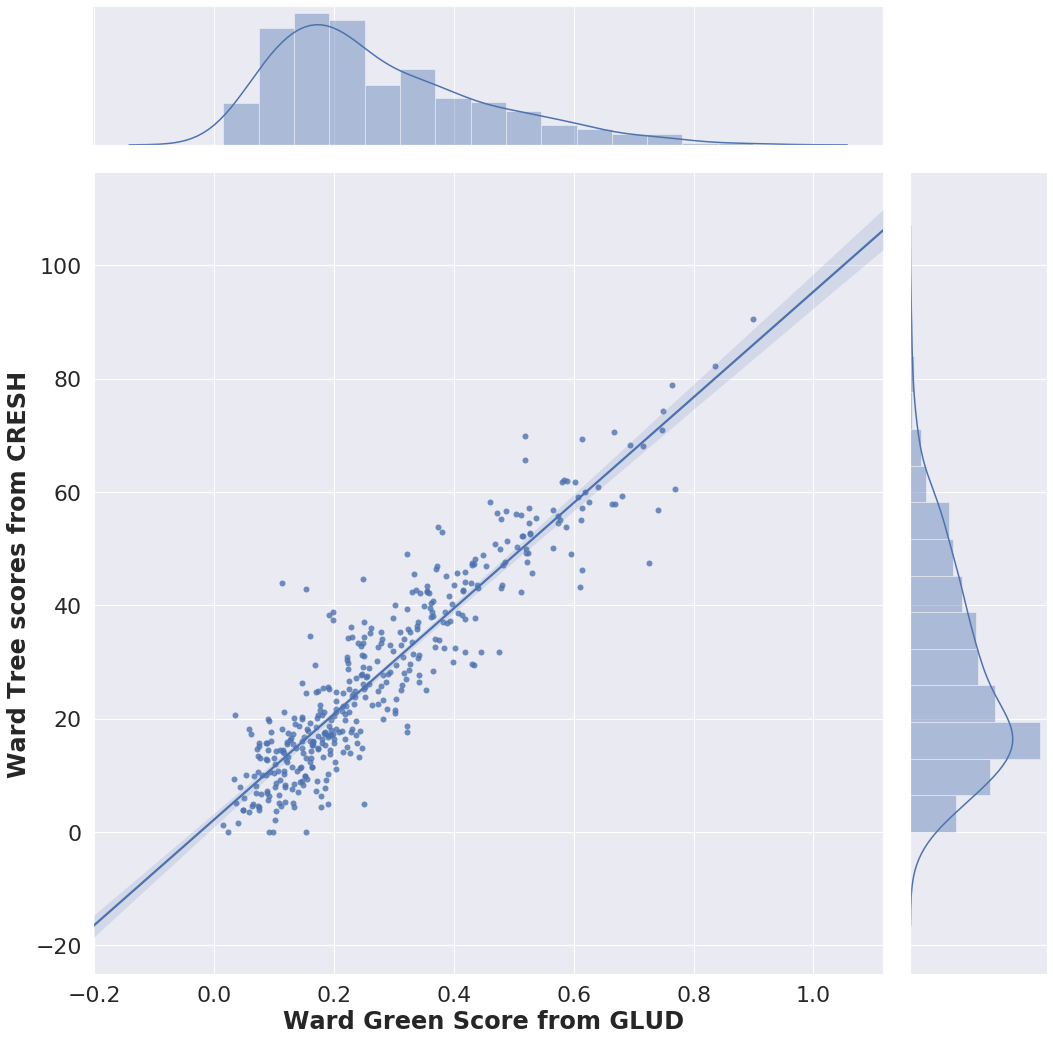

In [762]:
corr = pearsonr(merged_inner_GSV['GLUD_Area of Greenspace PCT'],merged_inner_GSV['green_score'])
print(corr)
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="GLUD_Area of Greenspace PCT", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Ward Green Score from GLUD ')
plt.ylabel('Ward Tree scores from CRESH')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

Text(0.5, 0, 'GSV to Satellite ratio (log)')

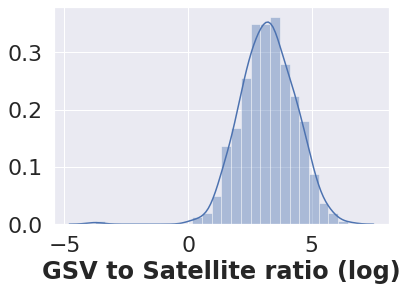

In [767]:
merged_inner_GSV['GSV_Sat_ratio'] = np.log(merged_inner_GSV['TreePixelDensity']/merged_inner_GSV['GLUD_Area of Greenspace PCT'])
sns.distplot(merged_inner_GSV['GSV_Sat_ratio'])
plt.xlabel('GSV to Satellite ratio (log)')

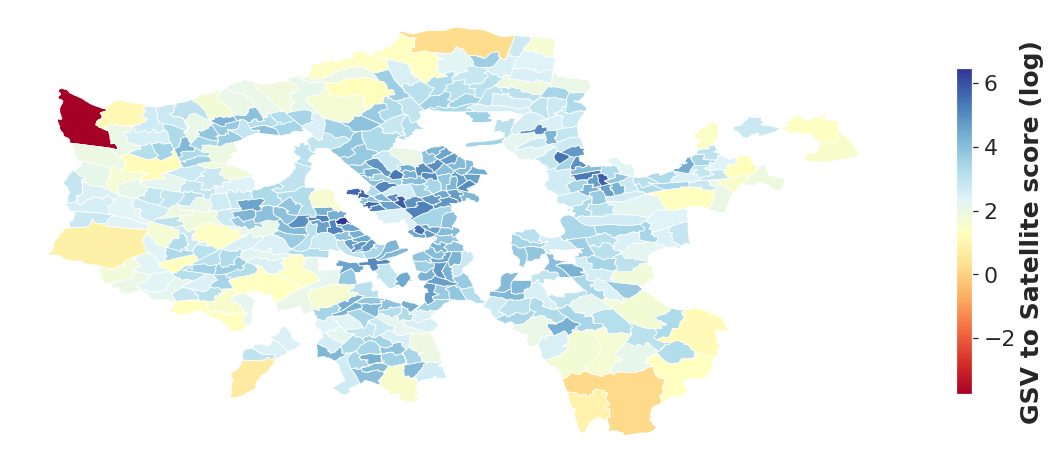

In [766]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
# ax.set_title('Good or Bad Solo', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='RdYlBu', norm=plt.Normalize(vmin=merged_inner_GSV['GSV_Sat_ratio'].min(), vmax=merged_inner_GSV['GSV_Sat_ratio'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
cbar.set_label('GSV to Satellite score (log)', fontsize = 25)
# solo_wards_shape.plot(ax=ax,column='Solo_quality', cmap='RdYlBu', linewidth=0.8)
merged_inner_GSV[merged_inner_GSV['GSV_Sat_ratio']!=0.0].plot(ax=ax,column='GSV_Sat_ratio', cmap='RdYlBu', linewidth=0.8)

(-0.6438438682318466, 6.744939442645257e-31)


Text(0.3, 4, 'Pearson r: -0.6***')

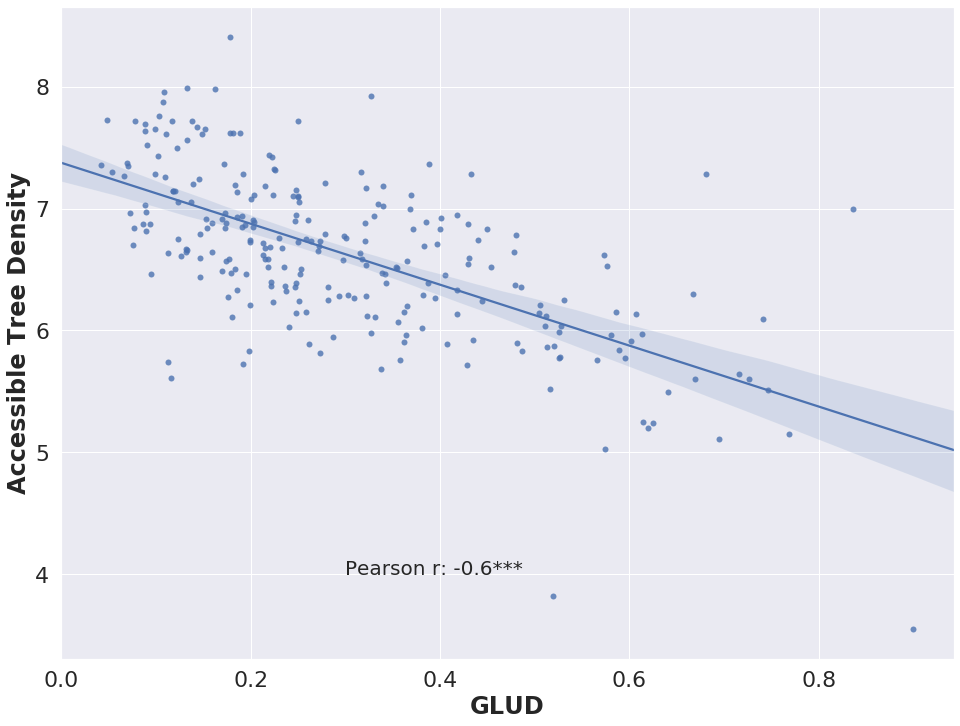

In [614]:
corr = pearsonr(merged_inner_GSV['GLUD_Area of Greenspace PCT'],merged_inner_GSV['TreeDensity'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="GLUD_Area of Greenspace PCT", y="TreeDensity", data=merged_inner_GSV);
plt.xlabel('GLUD')
plt.ylabel('Accessible Tree Density')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(0.3 , 4),fontsize = 20)

(-0.4517369031536256, 4.4749163949292044e-14)


Text(0.3, 3, 'Pearson r: -0.45***')

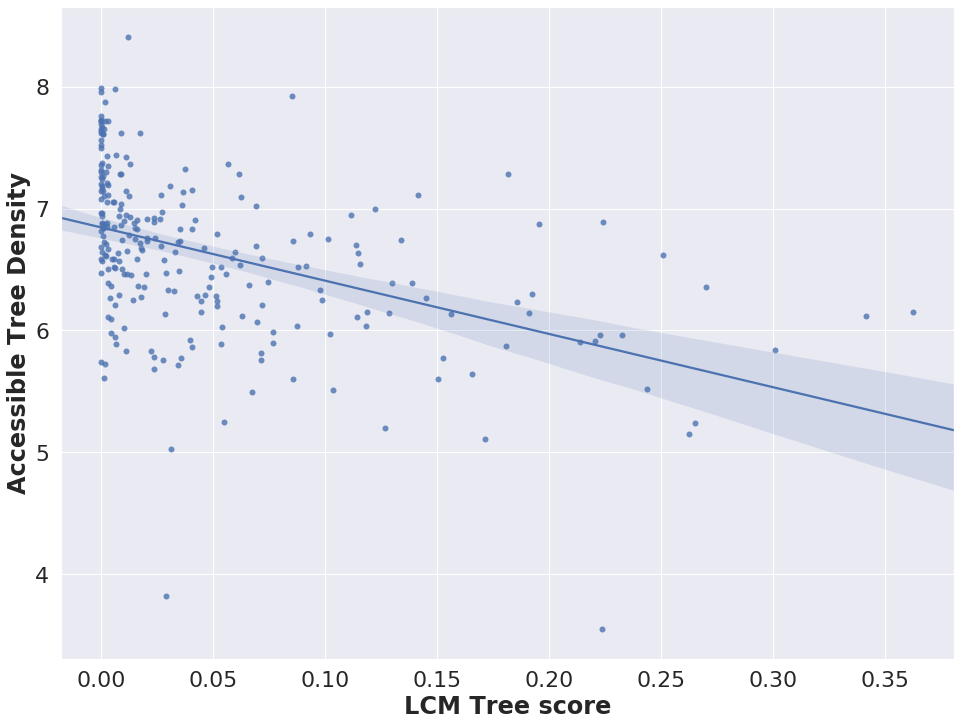

In [612]:
corr = pearsonr(merged_inner_GSV['LCM_tree_pct'],merged_inner_GSV['TreeDensity'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="LCM_tree_pct", y="TreeDensity", data=merged_inner_GSV);
plt.xlabel('LCM Tree score')
plt.ylabel('Accessible Tree Density')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(0.3 , 3),fontsize = 20)

In [424]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [425]:
diseases['201604'].keys()

dict_keys(['Ward_Prevalence', 'Ward_Prescriptions'])

In [426]:
diseases['201604']['Ward_Prescriptions'].keys()

dict_keys(['psoriasis', "Meniere's disease", "crohn's disease", 'rheumatoid', 'irritable bowel syndrome', 'parkinson', 'sleep apnea', 'interstitial cystitis', 'bipolar', 'hypothyroidism', 'dementia', 'gastroparesis', 'depression', 'diabetes'])

In [427]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , 'Prescriptions' : [] , 'Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data['Prescriptions'].append(dictionary1[k])
            data['Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe

In [428]:
depression = getDiseaase_frame(diseases, '201105' , 'depression')

In [429]:
# merged_inner_GSV

In [430]:
len(depression)

7483

In [431]:
merged_disease = pd.merge(left=merged_inner_GSV,right=depression, left_on='GSS_CODE', right_on='GSS_CODE')

In [433]:
# merged_disease['tree_pixels'] = np.log(merged_disease['tree_pixels'] + 1)

In [434]:
merged_disease.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0     15.68562  E05000026  E05000026                     0.199622   
1     24.04374  E05000027  E05000027                     0.229128   
2     18.21998  E05000028  E05000028                     0.058343   
3     56.84335  E05000029  E05000029                     0.741304   
4     58.17402  E05000030  E05000030                     0.459967   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.024752      0.009194       0.932815                0.064844   
1       0.138156      0.000000       0.858260                0.256912   
2       0.122918      0.000000       0.876416                0.157805   
3       0.185813      0.004209       0.423620                0.046093   
4       0.292064      0.030131       0.577416                0.459714   

   UA_Forests PCT  StreetTrees_PCT borough_name  TreePixelDensity  \
0             0.0         0.034379    E05000026          4.627208   
1             0.0         0.068538    E05000027          4.207532   
2             0.0         0.047912    E05000028          4.803945   
3             0.0         0.174167    E05000029          3.234714   
4             0.0         0.072611    E05000030          1.683950   

   TreeDensity  AccessTreeDensity  InAccessTreeDensity  Prescriptions  \
0     6.739450           5.734051             6.351481   56518.722449   
1     6.082104           5.193845             5.639416   75825.884050   
2     5.978550           5.572102             5.153722  100607.027835   
3     6.095361           4.652261             5.858569   91649.643590   
4     5.279865           4.427144             4.781984   65307.585932   

   Prevalence  
0    3.734800  
1    6.986629  
2    6.954723  
3    8.227078  
4    5.696754

(0.002952873815868371, 0.9512026068396884)


Text(0, 0.5, 'Rheumatoid Prevalence')

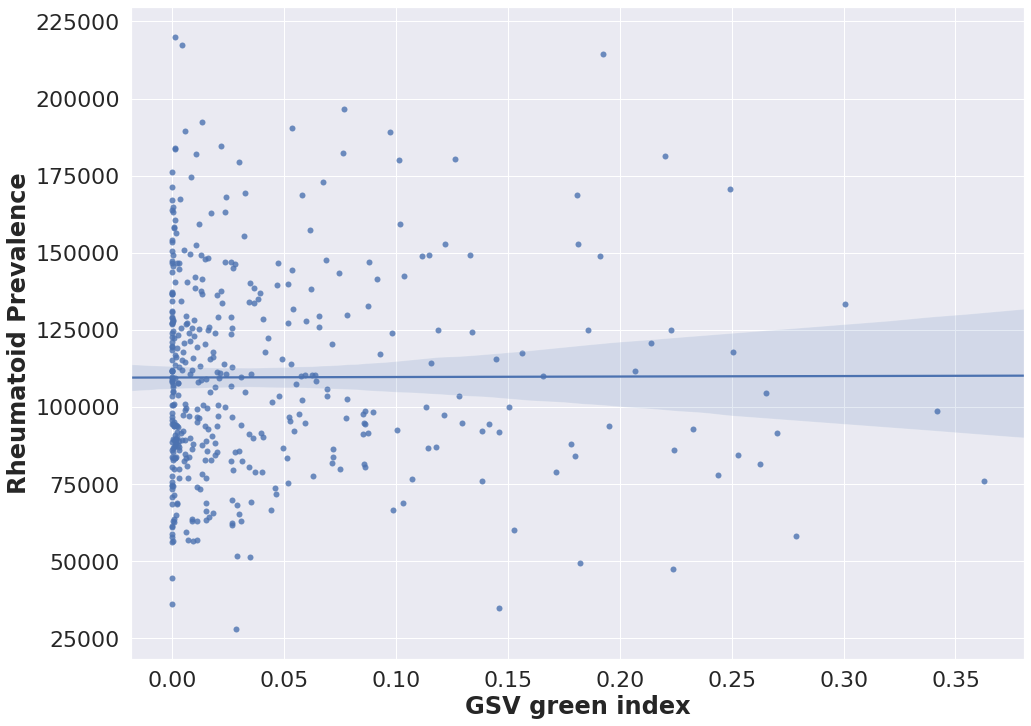

In [435]:
corr = pearsonr(merged_disease['LCM_tree_pct'],merged_disease['Prescriptions'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="LCM_tree_pct", y="Prescriptions", data=merged_disease);
plt.xlabel('GSV green index')
plt.ylabel('Rheumatoid Prevalence')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(0.15698967129373712, 0.0010609763607608604)


Text(0, 0.5, 'Depression Prevalence')

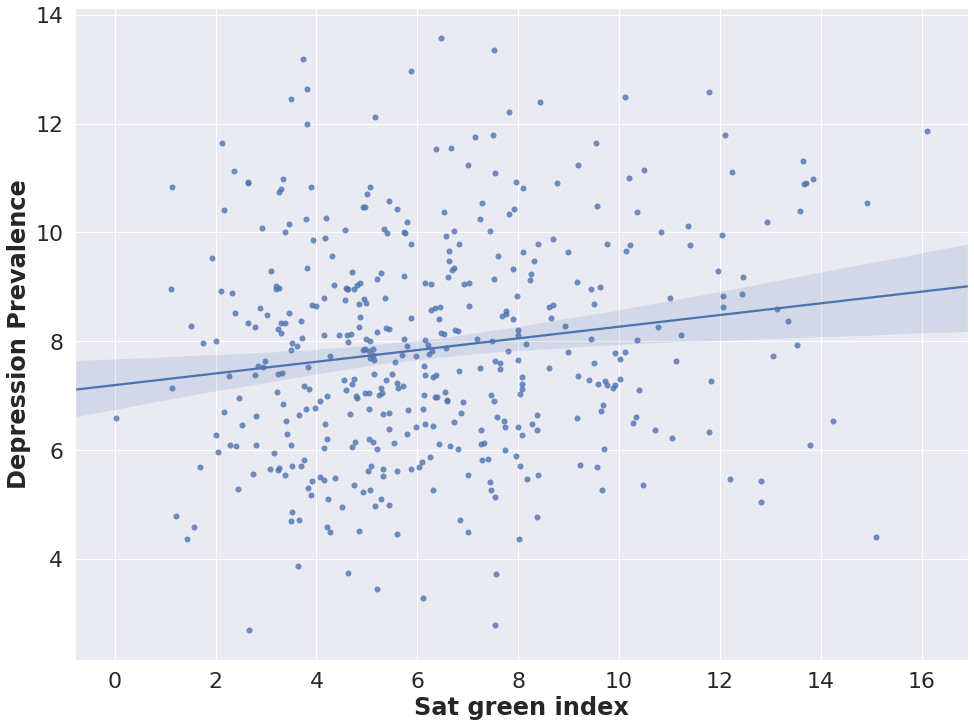

In [436]:
corr = pearsonr(merged_disease['TreePixelDensity'],merged_disease['Prevalence'])
print(corr)
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreePixelDensity", y="Prevalence", data=merged_disease);
plt.xlabel('Sat green index')
plt.ylabel('Depression Prevalence')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [437]:
merged_disease.corr()

green_score  GLUD_Area of Greenspace PCT  \
green_score                     1.000000                     0.916004   
GLUD_Area of Greenspace PCT     0.916004                     1.000000   
LCM_grass_pct                   0.779416                     0.830554   
LCM_tree_pct                    0.650297                     0.691837   
LCM_urban_pct                  -0.846592                    -0.840841   
UA_Public Greenery PCT          0.377513                     0.439282   
UA_Forests PCT                  0.432671                     0.448382   
StreetTrees_PCT                 0.266744                     0.152350   
TreePixelDensity               -0.703119                    -0.626362   
TreeDensity                    -0.333735                    -0.293339   
AccessTreeDensity              -0.390045                    -0.360662   
InAccessTreeDensity            -0.211321                    -0.177215   
Prescriptions                  -0.063606                    -0.023752   
Prevalence                     -0.014282                     0.043923   

                             LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  \
green_score                       0.779416      0.650297      -0.846592   
GLUD_Area of Greenspace PCT       0.830554      0.691837      -0.840841   
LCM_grass_pct                     1.000000      0.481098      -0.777235   
LCM_tree_pct                      0.481098      1.000000      -0.638977   
LCM_urban_pct                    -0.777235     -0.638977       1.000000   
UA_Public Greenery PCT            0.503037      0.388988      -0.402181   
UA_Forests PCT                    0.323112      0.612674      -0.441190   
StreetTrees_PCT                   0.065406     -0.105030      -0.230496   
TreePixelDensity                 -0.614193     -0.337290       0.654182   
TreeDensity                      -0.281748     -0.193729       0.309775   
AccessTreeDensity                -0.314458     -0.203361       0.352208   
InAccessTreeDensity              -0.196921     -0.150828       0.201790   
Prescriptions                    -0.064716      0.002953       0.051245   
Prevalence                        0.047726      0.080444      -0.025487   

                             UA_Public Greenery PCT  UA_Forests PCT  \
green_score                                0.377513        0.432671   
GLUD_Area of Greenspace PCT                0.439282        0.448382   
LCM_grass_pct                              0.503037        0.323112   
LCM_tree_pct                               0.388988        0.612674   
LCM_urban_pct                             -0.402181       -0.441190   
UA_Public Greenery PCT                     1.000000       -0.107526   
UA_Forests PCT                            -0.107526        1.000000   
StreetTrees_PCT                           -0.257904        0.085564   
TreePixelDensity                          -0.255552       -0.256948   
TreeDensity                               -0.151864       -0.103989   
AccessTreeDensity                         -0.161871       -0.111435   
InAccessTreeDensity                       -0.153724       -0.057772   
Prescriptions                             -0.148511        0.029133   
Prevalence                                -0.063495        0.111420   

                             StreetTrees_PCT  TreePixelDensity  TreeDensity  \
green_score                         0.266744         -0.703119    -0.333735   
GLUD_Area of Greenspace PCT         0.152350         -0.626362    -0.293339   
LCM_grass_pct                       0.065406         -0.614193    -0.281748   
LCM_tree_pct                       -0.105030         -0.337290    -0.193729   
LCM_urban_pct                      -0.230496          0.654182     0.309775   
UA_Public Greenery PCT             -0.257904         -0.255552    -0.151864   
UA_Forests PCT                      0.085564         -0.256948    -0.103989   
StreetTrees_PCT                     1.000000         -0.325104    -0.182671   
TreePixelDensity              